# 0-D Supply Utilization Model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


In [2]:
Food_Balance = pd.read_csv(r"..\Data\0DSUM\FAOSTAT_global-cereals-foodbalance_2010-2024.csv")

In [3]:
Food_Balance.Element.unique()

array(['Production', 'Import quantity', 'Stock Variation',
       'Export quantity', 'Domestic supply quantity', 'Feed', 'Seed',
       'Losses', 'Processing', 'Other uses (non-food)',
       'Tourist consumption', 'Residuals', 'Food',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)', 'Food supply (kcal)',
       'Protein supply quantity (g/capita/day)',
       'Protein supply quantity (t)',
       'Fat supply quantity (g/capita/day)', 'Fat supply quantity (t)'],
      dtype=object)

In [4]:
Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == 2010)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
8,FBS,Food Balances (2010-),1,World,5131,Processing,S2905,Cereals - Excluding Beer,2010,2010,1000 t,108911.0,E,Estimated value,NaN


In [5]:
Production_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-cereals-production_yearly_1961-2025.csv")
Pop_Data = pd.read_csv(r"../Data/0DSUM/FAOSTAT_global-population_1951-2025.csv")

Feed_proportion = []
Seed_proportion = []
Losses_proportion = []
Processing_proportion = []
Other_uses_proportion = []
Caloric_densities = []
for year in Food_Balance.Year.unique():
    Feed = Food_Balance[(Food_Balance.Element == 'Feed') & (Food_Balance.Year == year)].Value.values[0]
    Seed = Food_Balance[(Food_Balance.Element == 'Seed') & (Food_Balance.Year == year)].Value.values[0]
    Losses = Food_Balance[(Food_Balance.Element == 'Losses') & (Food_Balance.Year == year)].Value.values[0]
    Processing = Food_Balance[(Food_Balance.Element == 'Processing') & (Food_Balance.Year == year)].Value.values[0]
    Other_uses = Food_Balance[(Food_Balance.Element == 'Other uses (non-food)') & (Food_Balance.Year == year)].Value.values[0]
    Production = Food_Balance[(Food_Balance.Element == 'Production') & (Food_Balance.Year == year)].Value.values[0]

    Caloric_density = 1e6*Food_Balance[ (Food_Balance.Element == 'Food supply (kcal)') & (Food_Balance.Year == year)].Value.values[0]*(1/Food_Balance[(Food_Balance.Element == 'Food supply quantity (kg/capita/yr)') & (Food_Balance.Year == year)].Value.values[0])*(1/(Pop_Data[Pop_Data.Year == year].Value.values[0]*1000)) #kcal/year * cap*year/kg * 1/cap= kcal/kg
    
    Feed_proportion.append(Feed/Production)
    Seed_proportion.append(Seed/Production)
    Losses_proportion.append(Losses/Production)
    Processing_proportion.append(Processing/Production)
    Other_uses_proportion.append(Other_uses/Production)
    
    Caloric_densities.append(Caloric_density)



In [6]:
print("Seed proprtion is ", np.mean(Seed_proportion))
print("Feed proprtion is ", np.mean(Feed_proportion))   
print("Losses proprtion is ", np.mean(Losses_proportion))
print("Processing proprtion is ", np.mean(Processing_proportion))
print("Other uses proprtion is ", np.mean(Other_uses_proportion))
print("Caloric density is ", np.mean(Caloric_densities))


Seed proprtion is  0.026636729720242374
Feed proprtion is  0.33680755854898276
Losses proprtion is  0.04362604381094706
Processing proprtion is  0.0420743795443147
Other uses proprtion is  0.08865469481117141
Caloric density is  2609.596450423227


In [7]:
#
#
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Production_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-cereals-production_yearly_1961-2025.csv")
Pop_Data = pd.read_csv("../Data/0DSUM/FAOSTAT_global-population_1951-2025.csv")

years = Production_Data.Year.unique()[:-3]

addit = np.zeros(len(years))
addit[-10:] = 0.04
seed = 0.03
loss = 0.04
processing = 0#0.04
economic_use = addit#0#0.33 + 0.08+addit#0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. 
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

stocks = np.zeros(len(years))-0.01
#stocks[0] = stocks_obs[0]*1000
alpha = np.ones(len(years))

for i in np.arange(1,len(years)):
    Pop = Pop_Data[Pop_Data.Year == years[i]].Value.values[0]
    Y = Production_Data[Production_Data.Year == years[i]].Value.values[0]
    food = 1000*Pop*caloric_requirment/cereal_caloric_density # in tons
    SUR = 0.1#norm_cereal_price[commodity_prices.Year ==years[i]] # - 0.2
    if stocks[i-1] + (Y*(1-seed-loss) - alpha[i]*food*(1+processing) - Y*economic_use[i]) >= 0:
        alpha[i] = 1
    else:
        alpha[i] = (stocks[i-1] + Y*(1-seed-loss) - Y*economic_use[i])/(food*(1+processing))
        alpha[i] = alpha[i].clip(0,1)
    dstock = Y*(1-seed-loss) - alpha[i]*food*(1+processing) - Y*economic_use[i]
    stocks[i] = stocks[i-1] + dstock*SUR - stocks[i-1]*0.33



In [8]:
observed_stocks = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\0DSUM\USDA-PSD_global-eachcereals-beginningstocks_1960-2024.csv")
stocks_obs = []
year = []
for column in observed_stocks.columns[3:-1]:
    stocks_obs.append(np.char.replace(observed_stocks[column].values.astype(str), ",", "").astype(float).sum())
    year.append(int(column[0:4]))

Text(0, 0.5, 'Tons')

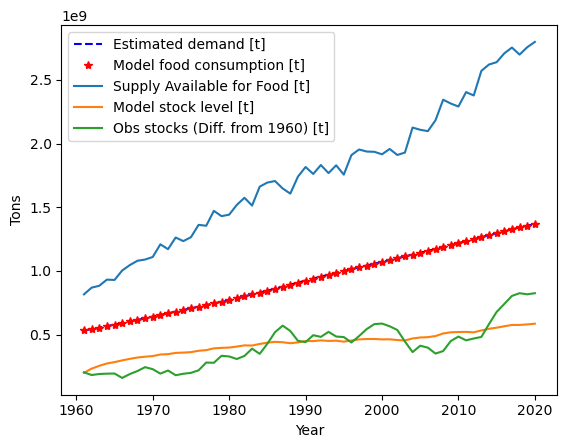

In [9]:
plt.plot(years,1000*Pop_Data.Value.values[11:-3]*caloric_requirment/cereal_caloric_density*(1+processing),'b--',label='Estimated demand [t]')
plt.plot(years,alpha*1000*Pop_Data.Value.values[11:-3]*caloric_requirment/cereal_caloric_density*(1+processing),'r*',label='Model food consumption [t]')
plt.plot(years,Production_Data.Value.values[:-3]*(1-seed-loss-economic_use[0]),label='Supply Available for Food [t]')
plt.plot(years,stocks+stocks_obs[0]*1000,label='Model stock level [t]')
plt.plot(years,1000*np.array(stocks_obs)[1:-1-3],label='Obs stocks (Diff. from 1960) [t]')
#plt.plot(commodity_prices.Year.unique()[61:],1000*np.max(stocks_obs)*mean_price[61:],label='world price')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Tons')


In [10]:
plt.plot(stocks/alpha*1000*Pop_Data.Value.values[11:]*caloric_requirment/cereal_caloric_density*(1+processing),label="SUR")
plt.legend()

ValueError: operands could not be broadcast together with shapes (60,) (63,) 

In [11]:
commodity_prices = pd.read_csv(r"C:/Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Geronimi-GYPrices-UpTo2020.csv")
commodity_prices.columns 

Index(['Year', 'Coffee', 'Cocoa', 'Tea', 'Rice', 'Wheat', 'Maize', 'Sugar',
       'Beef', 'Lamb', 'Banana', 'Palmoil', 'Cotton', 'Jute', 'Wool', 'Hides',
       'Tobacco', 'Rubber', 'Timber', 'Copper', 'Aluminum', 'Tin', 'Silver',
       'Lead', 'Zinc', 'MUV'],
      dtype='object')

In [12]:
np.convolve(np.ones(20)/20,world_avg_cereal_price,mode='full')

NameError: name 'world_avg_cereal_price' is not defined

In [13]:
trend = np.convolve(np.ones(20)/20,world_avg_cereal_price,mode='same')

NameError: name 'world_avg_cereal_price' is not defined

In [14]:
from scipy.signal import detrend

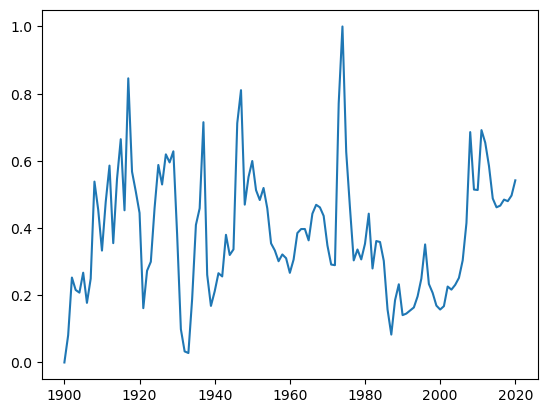

In [15]:
world_avg_cereal_price = (commodity_prices['Maize']+commodity_prices['Rice']+commodity_prices['Wheat'])/(3*commodity_prices['MUV'])
world_avg_cereal_price = detrend(world_avg_cereal_price, type='linear')
norm_cereal_price = (world_avg_cereal_price-np.min(world_avg_cereal_price))/(-np.min(world_avg_cereal_price)+np.max(world_avg_cereal_price))
plt.plot(commodity_prices.Year,norm_cereal_price,label='World price [USD/ton]')

# 1-D SUM
- Adding regional units coupled by import/export relationships
- Specify animal use: attempt to reproduce relative stock levels
- then add monthly trade ?

### a. Regional disaggregation:
Main questions at this scale: 
1. simple representation of trade quantities? i.e. a linear relationship of stocks differences and a coefficient of trade openness


In [16]:
#load data
UNSDA_conventions = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\UNSD-NamingConventions.csv",delimiter=';')
UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].isna(),"Intermediate Region Name"]=UNSDA_conventions.loc[UNSDA_conventions["Intermediate Region Name"].isna()]["Sub-region Name"]
UNSDA_conventions["Intermediate Region Name"].unique()
#UNSDA_conventions[UNSDA_conventions["ISO-alpha3 Code"]==national_animalfeed_use.Code.unique()[0]]["Intermediate Region Name"].values[0]

national_allocations = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT-OWID_bycountry-cereals-usage_1961-2022.csv")
regional_production = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-cereals-production_1961-2023.csv")
regional_trade =  pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-cereals-importexports_1961-2023.csv")
regional_population = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM\FAOSTAT_regional-population_1950-2023.csv")
region_mapping ={country:UNSDA_conventions[UNSDA_conventions["Country or Area"] == country]["Intermediate Region Name"].iloc[0] for country in UNSDA_conventions["Country or Area"].unique()}
national_allocations["Region"] = national_allocations['Entity'].map(region_mapping)

# Factual (i.e. FBS)

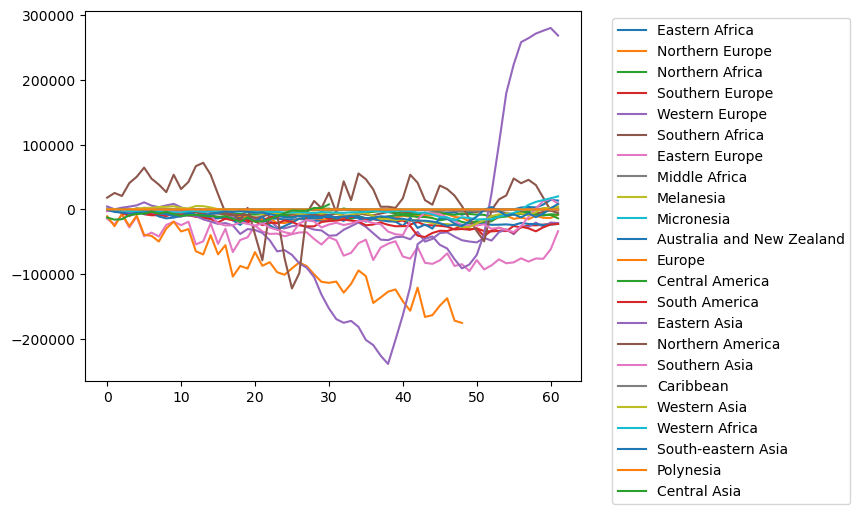

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the two CSV files
df_old = pd.read_csv('../Data/1DSUM/FAOSTAT_FBS-cereals-regional-1961-2013.csv')
df_new = pd.read_csv('../Data/1DSUM/FAOSTAT_FBS-cereals-regional-2010-2022.csv')

# Ensure 'Year' column is numeric
df_old['Year'] = pd.to_numeric(df_old['Year'], errors='coerce')
df_new['Year'] = pd.to_numeric(df_new['Year'], errors='coerce')

# Filter the old dataframe to include only years up to 2009
df_old_filtered = df_old[df_old['Year'] <= 2009]

# Combine the filtered old dataframe with the new dataframe
FAO_FBS_cereals = pd.concat([df_old_filtered, df_new], ignore_index=True)

# Optional: sort by year and reset index
FAO_FBS_cereals = FAO_FBS_cereals.sort_values(by='Year').reset_index(drop=True)
FAO_FBS_cereals['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
for country in FAO_FBS_cereals.Area.unique():
    plt.plot(np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Area == country) & (FAO_FBS_cereals.Element == "Stock Variation")]["Value"].values),label=country)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [17]:
# Filter the FAO_FBS_cereals dataframe for Melanesia
region = 'Middle Africa'
melanesia_data = FAO_FBS_cereals[FAO_FBS_cereals['Area'] == region]

residuals = np.zeros(len(melanesia_data.Year.unique()))
residuals[-len(melanesia_data[melanesia_data['Element'] == 'Residuals'].Value.values):] =melanesia_data[melanesia_data['Element'] == 'Residuals'].Value.values

# Calculate the supply-utilization balance
balance_data = (
    melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values +
    melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Stock Variation']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Food']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Feed']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Processing']['Value'].values -
    melanesia_data[melanesia_data['Element'] == 'Other uses (non-food)']['Value'].values
    - melanesia_data[melanesia_data['Element'] == 'Losses']['Value'].values
    - melanesia_data[melanesia_data['Element'] == 'Seed']['Value'].values
    - residuals
    #- melanesia_data[melanesia_data['Element'] == 'Tourist consumption']['Value'].values
)

# Plot the balance over the years
plt.figure(figsize=(10, 6))
plt.plot(melanesia_data['Year'].unique(), balance_data, label='Supply-Utilization Balance', marker='o')
#plt.axhline(0, color='red', linestyle='--', label='Zero Balance')
#vertical line showing the food balance sheet methodloigcal break
plt.axvline(x=2010, color='green', linestyle='-', label='Food Balance Sheet Methodological Break')
#add lines for indivual components 
plt.plot(melanesia_data[melanesia_data['Element'] == 'Production']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values, label='Production', linestyle='--')
#production net trade = production + import - export 
plt.plot(melanesia_data[melanesia_data['Element'] == 'Production']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Production']['Value'].values + melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values - melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values, label='Production net trade', linestyle='--')
#trade balance
plt.plot(melanesia_data[melanesia_data['Element'] == 'Import quantity']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Import quantity']['Value'].values - melanesia_data[melanesia_data['Element'] == 'Export quantity']['Value'].values, label='Trade balance', linestyle='--')
#Food consumption
plt.plot(melanesia_data[melanesia_data['Element'] == 'Food']['Year'].values, melanesia_data[melanesia_data['Element'] == 'Food']['Value'].values, label='Food consumption', linestyle='--')

plt.title('Supply-Utilization Balance for ' + region)
plt.xlabel('Year')
plt.ylabel('Balance (tonnes)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'FAO_FBS_cereals' is not defined

In [18]:
import warnings 
warnings.filterwarnings('ignore')

# Initialize dictionaries to store time series data for each region
regional_time_series = {region: [] for region in regional_production.Area.unique()[:-1]}

# Iterate over each region
for region in regional_production.Area.unique()[:-1]:
    # Filter national allocations for the current region
    #region_data = national_allocations[national_allocations['Region'] == region]
    region_data = FAO_FBS_cereals[FAO_FBS_cereals.Area == region] 
    #print(region)
    region_frame = []
    # Iterate over each year in the dataset
    for year in region_data['Year'].unique():
        # Filter data for the current year
        year_data = region_data[region_data['Year'] == year]

        # Calculate the sum of food, animal feed, other, and processing
        total_allocation = year_data[year_data.Element == "Production"]["Value"].iloc[0] + year_data[year_data.Element == "Import quantity"]["Value"].iloc[0] - year_data[year_data.Element == "Export quantity"]["Value"].iloc[0] -  year_data[year_data.Element == "Stock Variation"]["Value"].iloc[0]
        production = year_data[year_data.Element == "Production"]["Value"].iloc[0]
        #total_allocation = year_data[year_data.Element == "Production"]["Value"].iloc[0] + year_data[year_data.Element == "Import quantity"]["Value"].iloc[0] - year_data[year_data.Element == "Export quantity"]["Value"].iloc[0]
        # Calculate proportions for each category
        food_proportion = (
            year_data[year_data.Element == "Food"]["Value"].iloc[0] / total_allocation
        )
        feed_proportion = (
            year_data[year_data.Element == "Feed"]["Value"].iloc[0] / total_allocation
        )
        other_proportion = (
            year_data[year_data.Element == "Other uses (non-food)"]["Value"].iloc[0] / total_allocation
        )
        processing_proportion = (
            year_data[year_data.Element == "Processing"]["Value"].iloc[0] / total_allocation
        )
        seed_proportion = (
            year_data[year_data.Element == "Seed"]["Value"].iloc[0] / production
        )
        loss_proportion = (
            year_data[year_data.Element == "Losses"]["Value"].iloc[0] / production
        )
        netfood_proportion = (
            year_data[year_data.Element == "Food"]["Value"].iloc[0] / (year_data[year_data.Element == "Feed"]["Value"].iloc[0] + year_data[year_data.Element == "Food"]["Value"].iloc[0] + year_data[year_data.Element == "Processing"]["Value"].iloc[0] +  year_data[year_data.Element == "Other uses (non-food)"]["Value"].iloc[0])   
        )
        try:
            residuals_proportion = (
                (year_data[year_data.Element == "Residuals"]["Value"].iloc[0] + year_data[year_data.Element == "Tourist consumption"]["Value"].iloc[0] ) / total_allocation
            )
        except: 
            try:
                residuals_proportion = (
                (year_data[year_data.Element == "Residuals"]["Value"].iloc[0]) / total_allocation
                )
            except:
                residuals_proportion =0
                #print(year)
            # if there is an error, set all proportions to NaN
            #Food, Feed, Other, Processing, Seed, Losses, Residuals = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        # Append the proportions as a dictionary to the regional time series
        region_frame.append({
            'Year': year,
            'Food': food_proportion,
            'Feed': feed_proportion,
            'Other': other_proportion,
            'Processing': processing_proportion,
            'Seed': seed_proportion,
            'Losses': loss_proportion,
            'Residuals': residuals_proportion,
            'NetFood' : netfood_proportion,
        })
# Convert the lists of dictionaries to DataFrames for each region
    regional_time_series[region] = pd.DataFrame(region_frame).sort_values(by='Year', ascending=True,ignore_index=True)

# Now we can calculate the mean proportions for each region
# Assuming regional_time_series is a dictionary of DataFrames by region:
regions = list(regional_time_series.keys())

# Initialize an empty DataFrame to hold the mean proportions
mean_proportions = pd.DataFrame(columns=["Food", "Feed", "Other", "Processing", "Seed", "Losses", "Residuals", "Total","NetFood"])

# Iterate through each region
for region in regions:
    if region in regional_time_series:
        region_df = regional_time_series[region]
        yearly_sum = region_df.groupby("Year").sum()
        region_mean = yearly_sum.std()
        
        food = region_mean.get("Food", 0)
        feed = region_mean.get("Feed", 0)
        other = region_mean.get("Other", 0)
        processing = region_mean.get("Processing", 0)
        seed = region_mean.get("Seed", 0)
        losses = region_mean.get("Losses", 0)
        residuals = region_mean.get("Residuals", 0)
        total = food + feed + other + processing + seed + losses + residuals
        netfood = region_mean.get("NetFood", 0)

        mean_proportions.loc[region] = {
            "Food": food,
            "Feed": feed,
            "Other": other,
            "Processing": processing,
            "Seed": seed,
            "Losses": losses,
            "Residuals": residuals,
            "Total": total,
            "NetFood": netfood
        }
    else:
        print(f"Warning: Region '{region}' not found in dataset.")

# Display the result
print(mean_proportions)

NameError: name 'FAO_FBS_cereals' is not defined

# Counterfactual
Trade and production data are most reliable. Next, we can assume that people need at least 1260 calories from cereals. What's left in the SUA is a mix of economic usage + stockage, which can be interpreted as agro-indusrty capital?


In [19]:
USDAPSD_national_cereal_stocks = pd.read_csv(r"C:\Users\danie\Downloads\Untitled spreadsheet - USDA-PSD_national-eachcereals-beginningstocks_1960-2024.csv").ffill() #propogate forward missing values
not_current_countries = [
    "EU-15", "European Union", "Former Czechoslovakia", "Former Yugoslavia",
    "Serbia and Montenegro", "Union of Soviet Socialist Repu",
    "Yemen (Sanaa)", "Yemen (Aden)", "Yugoslavia (>05/92)"
] #either not a current state, or a state that has no data (Yemen aden and sanaa, manually verified. there is an independent entry for Yemen aggregated).
USDAPSD_national_cereal_stocks = USDAPSD_national_cereal_stocks[~USDAPSD_national_cereal_stocks["Country"].isin(not_current_countries)] #remove these countries from the dataset

In [20]:
def map_us_convention_to_un_convention(country):
    # This function maps country names from the USDA PSD naming convention to the UN naming convention.
    # Gemeneni Pro 2.5 did this task really well, GPT 4.0 didn't. 
    # --- User's existing conditions ---
    if country == 'Czech Republic':
        country = 'Czechia'
    elif country == 'Congo (Kinshasa)':
        country = 'Democratic Republic of the Congo'
    elif country == 'Congo (Brazzaville)':
        # Assuming 'Congo' in the UN list refers to the Republic of the Congo
        country = 'Congo'
    elif country == 'Korea, South':
        country = 'Republic of Korea'
    elif country == 'Korea, North':
        country = "Democratic People's Republic of Korea"
    elif country == 'Taiwan': # UN does not list Taiwan separately
        country = 'China'
    elif country == 'Turkey':
        country = 'Türkiye'
    elif country == 'Vietnam':
        country = 'Viet Nam'
    elif country == 'Burma':
        country = 'Myanmar'
    elif country == "Cote d'Ivoire":
        # Note the different apostrophe and capitalization in the UN list
        country = 'Côte d’Ivoire'
    elif country == 'Gambia, The':
        country = 'Gambia'

    # --- New conditions based on list comparison ---
    elif country == 'Bolivia':
        country = 'Bolivia (Plurinational State of)'
    elif country == 'Brunei':
        country = 'Brunei Darussalam'
    elif country == 'Congo': # If the American list uses just 'Congo'
         # Assuming 'Congo' in the UN list refers to the Republic of the Congo
        country = 'Congo'
    elif country == 'Hong Kong':
        country = 'China, Hong Kong Special Administrative Region'
    elif country == 'Iran':
        country = 'Iran (Islamic Republic of)'
    elif country == 'Laos':
        country = "Lao People's Democratic Republic"
    elif country == 'Macau':
        country = 'China, Macao Special Administrative Region'
    elif country == 'Moldova':
        country = 'Republic of Moldova'
    elif country == 'Russia':
        country = 'Russian Federation'
    elif country == 'Syria':
        country = 'Syrian Arab Republic'
    elif country == 'Tanzania':
        country = 'United Republic of Tanzania'
    elif country == 'United Kingdom':
        country = 'United Kingdom of Great Britain and Northern Ireland'
    elif country == 'United States':
        country = 'United States of America'
    elif country == 'Venezuela':
        country = 'Venezuela (Bolivarian Republic of)'
    # Reunion needs accent correction if present in Am list (it was in UN list)
    elif country == 'Reunion':
         country = 'Réunion'
    # Add any other specific mappings needed based on your data source
    return country

In [21]:
regional_cereals_stocks_obs = {region:np.zeros(len(USDAPSD_national_cereal_stocks.columns[3:-1])) for region in regional_production.Area.unique()}
rcs_years = {region:[] for region in regional_production.Area.unique()}
for country in USDAPSD_national_cereal_stocks.Country.unique():
    country_stocks = []    
    years = []
    for column in USDAPSD_national_cereal_stocks.columns[3:-1]:
        country_stocks.append(np.char.replace(USDAPSD_national_cereal_stocks[USDAPSD_national_cereal_stocks.Country==country][column].values.astype(str), ",", "").astype(float).sum())
        years.append(int(column[0:4]))
    country = map_us_convention_to_un_convention(country)
    region_of_country  = [region_mapping[key] for key in region_mapping.keys() if key.__contains__(country)][0] #slightly more complicated, but necessary because the dictionary keys sometimes contain more than the basic country name.
    rcs_years[region_of_country] = years
    regional_cereals_stocks_obs[region_of_country] += np.array(country_stocks)
#Convert to a pandas DataFrame for easier manipulation
# Build a list of rows
rows = []
for region in regional_cereals_stocks_obs:
    stocks = regional_cereals_stocks_obs[region]
    years = rcs_years[region]
    
    for stock, year in zip(stocks, years):
        rows.append({
            "region": region,
            "stock": stock,
            "Year": year
        })

# Convert list of rows into a DataFrame
regional_stocks_df = pd.DataFrame(rows)
    


FAOStat and USDA PSD cereal data on stocks disagree strongly: this is because of the high sensitivity of supply-utilization balance methodology to parameters of use like feed.
https://www.fao.org/fileadmin/templates/est/meetings/stocks/Abbott-Lessons_from_Recent_Stocks_Adjustments.pdf

In general, the suppply utilization balance is not a reliable empirical tool: it's in most cases strongly underidentified. However, we can consider a more theroetical case: agricultural capital. This is like a Solow-Model of agricultural sufficiency: there is savings, and "investment" which is not just in agriculture, but 

Text(0, 0.5, 'stocks')

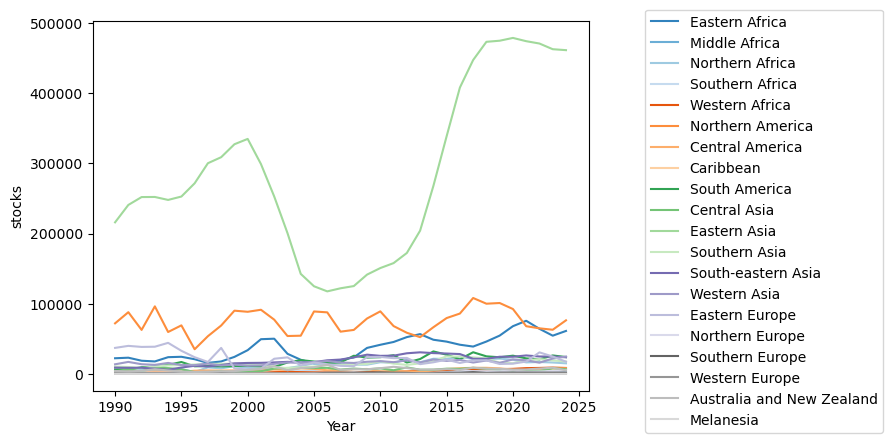

In [303]:
fig = plt.figure()
ax = plt.subplot(111)
for r,region in enumerate(list(regional_cereals_stocks_obs.keys())[:-1]):
        plt.plot(rcs_years[region][30:],regional_cereals_stocks_obs[region][30:],label=region,color=colors[r])
        #plt.plot(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Area==region) & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))]["Year"].values,regional_cereals_stocks_obs[region][0]+np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Area==region) & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))]["Value"].values),label=region+" FAO",color=colors[r],linestyle='--')
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('stocks')
 

In [22]:
global_stock_ts = np.array(list(regional_cereals_stocks_obs.values())).sum(axis=0)[31:-2]
FAO_gsts= np.cumsum(-FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Year.isin(rcs_years[region][:]))].groupby("Year")["Value"].sum().values)

NameError: name 'FAO_FBS_cereals' is not defined

In [23]:
FAO_national_cereal_stocks_changeregional_cereals_stocks_obs = {region:np.zeros(len(USDAPSD_national_cereal_stocks.columns[3:-1])) for region in regional_production.Area.unique()}
rcs_years = {region:[] for region in regional_production.Area.unique()}
for country in USDAPSD_national_cereal_stocks.Country.unique():
    country_stocks = []    
    years = []
    for column in USDAPSD_national_cereal_stocks.columns[3:-1]:
        country_stocks.append(np.char.replace(USDAPSD_national_cereal_stocks[USDAPSD_national_cereal_stocks.Country==country][column].values.astype(str), ",", "").astype(float).sum())
        years.append(int(column[0:4]))
    country = map_us_convention_to_un_convention(country)
    region_of_country  = [region_mapping[key] for key in region_mapping.keys() if key.__contains__(country)][0] #slightly more complicated, but necessary because the dictionary keys sometimes contain more than the basic country name.
    rcs_years[region_of_country] = years
    regional_cereals_stocks_obs[region_of_country] += np.array(country_stocks)
#Convert to a pandas DataFrame for easier manipulation
# Build a list of rows
rows = []
for region in regional_cereals_stocks_obs:
    stocks = regional_cereals_stocks_obs[region]
    years = rcs_years[region]
    
    for stock, year in zip(stocks, years):
        rows.append({
            "region": region,
            "stock": stock,
            "Year": year
        })

# Convert list of rows into a DataFrame
regional_stocks_df = pd.DataFrame(rows)
    

#### Testing chronic food undersupply

In [24]:
seed = 0.03
loss = 0.04
processing = 0.04
economic_use = 0.33  + 0.08+addit# 0*np.hstack([World_otheruse,World_otheruse[-1]])/100 # 35% for animal consumption. World other use is extended by one year. #
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

years = regional_production.Year.unique()
years = years[30:-3]

stocks = np.zeros((len(regional_production.Area.unique()),len(years)))-0.01
percapita_stocks = np.zeros((len(regional_production.Area.unique()),len(years)))-0.01


alpha = np.ones((len(regional_production.Area.unique()),len(years)))
for r,region in enumerate(regional_production.Area.unique()[0:-1]):
    #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
    seed = 0.03
    loss = 0.04
    cereal_caloric_density = 2609*1000 # kcal/ton 
    caloric_requirment = 1240*365 # 1200 kcal/year
    stocks[r,0] = regional_cereals_stocks_obs[region][30]*1000
    for i in np.arange(1,len(years)):
        #food_supply = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Food
        #seed = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Losses
        #loss = regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Seed
        processing = 0# regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Processing
        economic_use = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Other + regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Feed
        Pop = 1000*regional_population[(regional_population.Year == years[i]) & (regional_population.Area == region )].Value.values[0] #[1000 people]
        residuals = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Residuals
        Y = regional_production[(regional_production.Year == years[i]) & (regional_production.Area == region )].Value.values[0] #[tons]
        stock_use_ratio = 1-norm_cereal_price[commodity_prices.Year ==years[i]]
        
        try:
            trade_balance = regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Import quantity')].Value.values[0] - regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Export quantity')].Value.values[0] #[tons]
            world_pop = np.sum(regional_population[(regional_population.Year == years[i])].Value.values)
            #trade_balance = (np.delete(stocks[:,i-1],r).sum()- stocks[r,i-1]) * (0.1)
        except:
            trade_balance =0 
            print(region)
            #print(years[i])
        if region == 'Northern America':
            economic_use=economic_use#+0.4 #if lots of beer is produced
            #trade_balance = 1*(regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Import quantity')].Value.values[0] - 2*regional_trade[(regional_trade.Year == years[i]) & (regional_trade.Area == region ) & (regional_trade.Element == 'Export quantity')].Value.values[0]) #[tons]
        food = Pop*caloric_requirment/cereal_caloric_density # in tons
        total_supply = Y+trade_balance
        if stocks[r,i-1] + trade_balance + (Y*(1-seed-loss) - alpha[r,i]*food*(1+processing) - total_supply*economic_use) > 0:
            alpha[r,i] = 1
        else:
            alpha[r,i] = (stocks[r,i-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
            alpha[r,i] = alpha[r,i].clip(0,1)
        dstock = trade_balance + Y*(1-seed-loss) - alpha[r,i]*food - total_supply*(economic_use+processing+residuals)
        stocks[r,i] = stocks[r,i-1] + dstock - stocks[r,i-1]*0.33 #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
        percapita_stocks[r,i] = stocks[r,i]/Pop



Text(0, 0.5, 'alpha')

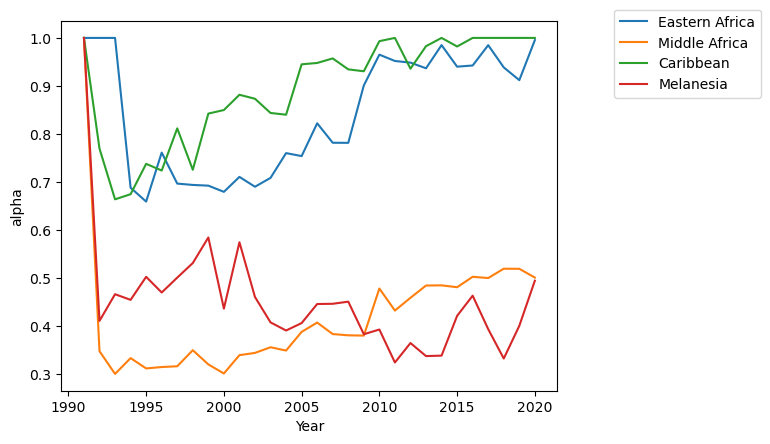

In [ ]:


colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)

for r,region in enumerate(regional_production.Area.unique()):
    if alpha[r,:].mean()<1: #(region == "Western Africa"):
        plt.plot(years,alpha[r,:],label=region)#color=colors[r])
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('alpha')


NameError: name 'FAO_FBS_cereals' is not defined

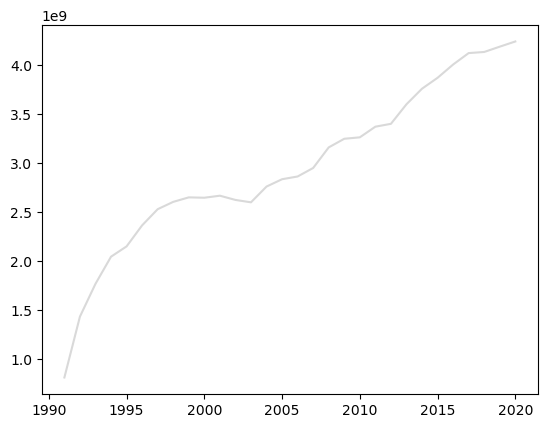

In [27]:

plt.plot(years,np.sum(stocks[:-1,:],axis=0),color=colors[r],label="World Stocks (model)")
FAO_gsts= 1000*np.cumsum(FAO_FBS_cereals[(FAO_FBS_cereals.Element=="Stock Variation") & (FAO_FBS_cereals.Year.isin(years))].groupby("Year")["Value"].sum().values)
plt.plot(years,FAO_gsts)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('stocks')
plt.xlabel('Year')

#### analyze correlations in trade with production 

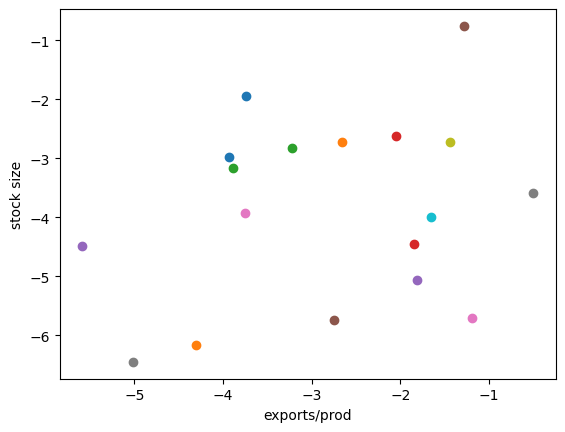

In [28]:
import scipy.signal
for region_of_interest,region_name in enumerate(regional_production.Area.unique()[0:-2]):
    #
    if region_name != "Eastern Asia":
        exports= regional_trade[(regional_trade.Area == regional_production.Area.unique()[region_of_interest] ) & (regional_trade.Element == 'Export quantity')].Value.values 
        imports = regional_trade[(regional_trade.Area == regional_production.Area.unique()[region_of_interest] ) & (regional_trade.Element == 'Import quantity')].Value.values 
        prod = regional_production[(regional_production.Area == regional_production.Area.unique()[region_of_interest]) & (regional_production.Element == 'Production')].Value.values
        trade_balance = imports-exports
        #
        region_stocks = regional_cereals_stocks_obs[region_name]
        maxstock = np.max([stock.mean() for stock in regional_cereals_stocks_obs.values()])
        stock_difference = np.zeros(len(region_stocks))

    # for r in range(len(regional_production.Area.unique()[0:-1])):
    #     if r != region_of_interest:
    #         stock_difference= stock_difference +stocks[r,:]

        #stock_difference = stock_difference - stocks[region_of_interest,:]

        #plt.plot(stock_difference,trade_balance[30:-1],label=region_name)
        variable1 = exports  
        variable2 = prod
        #plt.plot(exports/prod)
        correlation =np.corrcoef(scipy.signal.detrend(variable1),scipy.signal.detrend(variable2))[0,1]
        #plt.scatter(scipy.signal.detrend(variable1),scipy.signal.detrend(variable2),label=region_name+" R2="+str(round(correlation,2)))
        #oddly enough, in Eastern and Middle Africa, production of cereals is quite correlated with imports of cereals. This is obviously not expected.
        #the ratio of imports or exports to production is actually only around 0.2/0.1 in Middle/Eastern Africa, which is not that high compared to 0.65 in Northern Africa. its like 0.2 in western europe.
        #print(region_name)
        #print(np.mean(np.round(exports/prod,3)))
        plt.scatter(np.log(np.mean(np.round(exports/prod,3))),np.log(region_stocks.mean()/maxstock),label=region_name)
        #plt.legend()
        plt.xlabel('exports/prod')
        plt.ylabel('stock size')

### a. National disaggregation:
Main assumptions:
1. Trade is exogenous (as it appears to be -- without analysis -- in the regional data)

Main questions at this scale: 
1. 


In [29]:
#Food Survey Consumption Share data analysis
FoodConsumptionSurveyShares = pd.read_csv(r"..\Data\1DSUM\FAOSTAT_Intake-national-surveys.csv")
def split_names(name):
    try: 
      name = int(name.split("-")[1])
    except:
      name = int(name.split("-")[2])
    return name
FoodConsumptionSurveyShares["Country"] = [name.split("-")[0] for name in FoodConsumptionSurveyShares["Survey"].values]
FoodConsumptionSurveyShares["Year"] = [split_names(name) for name in FoodConsumptionSurveyShares["Survey"].values]

cereal_ratios = []
all_cons =[]
for country in FoodConsumptionSurveyShares["Country"].unique():
    if np.sum((FoodConsumptionSurveyShares["Country"]==country)*(FoodConsumptionSurveyShares["Food Group"]=='All food groups')) > 1:
        print(country)
        all_food_cons = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Value.iloc[1] - FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Value.iloc[0]
        cereal_cons = FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='Cereals and their products')].Value.iloc[1] - FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='Cereals and their products')].Value.iloc[0]
        print(all_food_cons)
        print(cereal_cons)
        if country == "Niger ":
            print(FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Year.values)
        if country == "Burkina Faso ":
            print(FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Year.values)   
        if country == "Mali ":
            print(FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Year.values)
        if country == "Ethiopia ":
            print(FoodConsumptionSurveyShares[(FoodConsumptionSurveyShares["Country"]==country) & (FoodConsumptionSurveyShares["Food Group"]=='All food groups')].Year.values)
        cereal_ratio = (cereal_cons/all_food_cons)
        cereal_ratios.append(cereal_ratio)
        #all_cons.append(all_food_cons)

#These changes in caloric intake, both total and of cereals, are not reflected in the FAO food availabiliy data. at best a third is reflected.

Armenia 
59
28
Bangladesh 
-95
-209
Benin 
35
123
Burkina Faso 
-104
-158
[2019 2022]
Côte d'Ivoire 
-100
-24
Ethiopia 
-67
-115
[2016 2019]
Guinea
245
-25
Kazakhstan 
-181
-26
Malawi 
61
-17
Mali 
-545
-368
[2019 2022]
Mexico 
-115
18
Niger 
219
220
[2019 2022]
Pakistan 
43
-39
Peru 
-150
-8
Senegal 
3
58
Togo 
-90
20


# Empirical Drivers of Undernutrition Changes in Middle, West, and Middle Africa last twenty years.
going beyond a 'residual accumulation of errors' (hays 1978)

In [44]:
National_Roads = pd.read_csv(r"..\Data\1DSUM-National\EHDR_Replication_Files\roads+rails_all-1960-2015.csv")
National_LandArea = pd.read_excel(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\1DSUM-National\EHDR_Replication_Files\area.xls")

In [45]:
# Forecast paved and rail_km for years 2016-2023 using linear fitting on 2011-2015 data.
forecast_rows = []
# Assuming your National_Roads dataframe contains a column named "Country". 
for country, group in National_Roads.groupby("country"):
    # Select training data for 2011-2015
    train = group[(group['year'] >= 2011) & (group['year'] <= 2015)]
    # Ensure there are enough data points
    if train.shape[0] < 2:
        continue  # skip countries with insufficient data
    # Fit a linear model for each variable
    coeffs_paved = np.polyfit(train['year'], train['paved'], 1)
    coeffs_rail = np.polyfit(train['year'], train['rail_km'], 1)
    # Forecast for years 2016 to 2023
    for yr in range(2016, 2024):
        paved_pred = np.polyval(coeffs_paved, yr)
        rail_pred = np.polyval(coeffs_rail, yr)
        forecast_rows.append({
            "country": country,
            "year": yr,
            "paved": paved_pred,
            "rail_km": rail_pred
            # add any other fields necessary; if in your original data there are additional columns,
            # consider adding them here (or leave them as NaN)
        })
forecast_df = pd.DataFrame(forecast_rows)
print(forecast_df.head())

# To append to your original National_Roads dataframe:
National_Roads_extended = pd.concat([National_Roads, forecast_df], ignore_index=True)
print(National_Roads_extended.tail())

  country  year        paved      rail_km
0  Angola  2016  9167.015179  3097.292221
1  Angola  2017  9167.015179  3097.292221
2  Angola  2018  9167.015179  3097.292221
3  Angola  2019  9167.015179  3097.292221
4  Angola  2020  9167.015179  3097.292221
      Unnamed: 0   country  year      rail_km  map  highway        paved  \
2747         NaN  Zimbabwe  2019  2633.235571  NaN      NaN  8394.522391   
2748         NaN  Zimbabwe  2020  2633.235571  NaN      NaN  8394.522391   
2749         NaN  Zimbabwe  2021  2633.235571  NaN      NaN  8394.522391   
2750         NaN  Zimbabwe  2022  2633.235571  NaN      NaN  8394.522391   
2751         NaN  Zimbabwe  2023  2633.235571  NaN      NaN  8394.522391   

      improved  paved2  pavimp  lhighway  lpaved  limproved  lpaved2  lpavimp  \
2747       NaN     NaN     NaN       NaN     NaN        NaN      NaN      NaN   
2748       NaN     NaN     NaN       NaN     NaN        NaN      NaN      NaN   
2749       NaN     NaN     NaN       NaN     NaN

In [46]:
africa_mapping = {
    "Angola": "Angola",
    "Benin": "Benin",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cabo Verde": "Cabo Verde",
    "Cameroon": "Cameroon",
    "Central African Republic": "Central African Republic",
    "Chad": "Chad",
    "Comoros": "Comoros",
    "Congo, Rep.": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Djibouti": "Djibouti",
    "Equatorial Guinea": "Equatorial Guinea",
    "Eritrea": "Eritrea",
    "Ethiopia": "Ethiopia",
    "Gabon": "Gabon",
    "Gambia, The": "Gambia",
    "Ghana": "Ghana",
    "Guinea": "Guinea",
    "Guinea-Bissau": "Guinea-Bissau",
    "Kenya": "Kenya",
    "Liberia": "Liberia",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Mali": "Mali",
    "Mauritania": "Mauritania",
    "Mauritius": "Mauritius",
    "Mozambique": "Mozambique",
    "Niger": "Niger",
    "Nigeria": "Nigeria",
    "Rwanda": "Rwanda",
    "Sao Tome and Principe": "Sao Tome and Principe",
    "Senegal": "Senegal",
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Somalia": "Somalia",
    "South Sudan": "South Sudan",
    "Togo": "Togo",
    "Uganda": "Uganda",
    "Tanzania": "United Republic of Tanzania",
    "Zambia": "Zambia",
    "Zimbabwe": "Zimbabwe"
}
africa_mapping_reversed = {v: k for k, v in africa_mapping.items()}
print(africa_mapping_reversed)

{'Angola': 'Angola', 'Benin': 'Benin', 'Burkina Faso': 'Burkina Faso', 'Burundi': 'Burundi', 'Cabo Verde': 'Cabo Verde', 'Cameroon': 'Cameroon', 'Central African Republic': 'Central African Republic', 'Chad': 'Chad', 'Comoros': 'Comoros', 'Congo': 'Congo, Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Djibouti': 'Djibouti', 'Equatorial Guinea': 'Equatorial Guinea', 'Eritrea': 'Eritrea', 'Ethiopia': 'Ethiopia', 'Gabon': 'Gabon', 'Gambia': 'Gambia, The', 'Ghana': 'Ghana', 'Guinea': 'Guinea', 'Guinea-Bissau': 'Guinea-Bissau', 'Kenya': 'Kenya', 'Liberia': 'Liberia', 'Madagascar': 'Madagascar', 'Malawi': 'Malawi', 'Mali': 'Mali', 'Mauritania': 'Mauritania', 'Mauritius': 'Mauritius', 'Mozambique': 'Mozambique', 'Niger': 'Niger', 'Nigeria': 'Nigeria', 'Rwanda': 'Rwanda', 'Sao Tome and Principe': 'Sao Tome and Principe', 'Senegal': 'Senegal', 'Seychelles': 'Seychelles', 'Sierra Leone': 'Sierra Leone', 'Somalia': 'Somalia', 'South Sudan': 'Sout

In [179]:
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

#0. load data
#a) FAOStat Agricultural Data
National_Income = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-income_1970-2022.csv")
National_Trade = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-importexports-1961-2023.csv")
National_AgEmpShares = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-employmentsharesagriculture-2000-2021.csv")
National_Populations = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv")
National_Cereals_Production = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-production_1961-2023.csv")
#b) FAOStat Food Security Indicators 
National_Food_Security_Indicators = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_4FoodSecurityIndicators-SSA-MinusSouthAfrica.csv")
original_data = National_Food_Security_Indicators["Year"].unique()
#Replace the items labeled by a three year average with the central year value, for better intercomparability.  Use a dictionary comprehension, assuming clean data ('YYYY-YYYY+2' format for ranges)
replace_map = {
    item: str(int(item.split('-')[0]) + 1)  # value: Calculate central year string
    for item in original_data               # iterate over each element
    if isinstance(item, str) and '-' in item # condition: element is a string & contains hyphen
}
National_Food_Security_Indicators["Year"].replace(replace_map, inplace=True) # replace values in the DataFrame
#Fill incomplete rail line density data
National_Food_Security_Indicators[National_Food_Security_Indicators["Item"]=='Rail lines density (total route in km per 100 square km of land area)'].ffill()

# c) Convert Year columns in all dataframes to integer
print("Converting 'Year' columns to integer...")
for df_name, df in [('IncomeAg', National_Income), ('Trade', National_Trade),
                     ('AgEmpShares', National_AgEmpShares), ('Populations', National_Populations),
                     ('Cereals', National_Cereals_Production),('FSI',National_Food_Security_Indicators)]:
    if 'Year' in df.columns:
        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df.dropna(subset=['Year'], inplace=True)
        df['Year'] = df['Year'].astype(int)
    else:
        print(f"Warning: 'Year' column not found in {df_name}")
print("'Year' column conversion complete.")

#2. Get a list of all variables to be used in the time series matrix. 

all_variables = ['Road Density','Rural Pop. Percent','Cereals Production (per Capita)','Cereals Trade Balance (per Capita)','GDP (per Capita)','Conflict Index','Share of AFS employment in total employment','Share of agricultural employment in total AFS employment','Gross National Income (per Capita, USD)','Cereals Production Net Trade (kcal/capita/day)']#all variable names here: one for each of the first five (national_incomeag,...NAtional_cereals_Production), except for IncomeAg the first one, which has two different items. Also Trade has imports and exports (two seperate items) from which I want just a variable for the trade balance. Also Populations has both toal populations and rural/urban population. I want just one from that one: rural population/total population. Essentially can do item.unique if needed

#also, the below code should normalize to a per capita basis the trade balance and production 
#target_timeseries = np.zeros((len(National_Food_Security_Indicators.Area.unique()),len(National_Food_Security_Indicators.Year.unique())))

#2.here we combine all the variables into a single time series matrix 

areas = National_Food_Security_Indicators['Area'].unique()
years = National_Food_Security_Indicators['Year'].unique()
data_timeseries = np.zeros((len(all_variables),len(areas),len(years)))

def get_total_population(area, year):
    df_tot = National_Populations[(National_Populations['Area'] == area) &
                                  (National_Populations['Year'] == year) &
                                  (National_Populations['Element'] == 'Total Population - Both sexes')]
    if not df_tot.empty:
        pop = df_tot['Value'].iloc[0]
        if '1000' in df_tot['Unit'].iloc[0]:
            pop *= 1000
        return pop
    return np.nan

def get_rural_population(area, year):
    df_rural = National_Populations[(National_Populations['Area'] == area) &
                                    (National_Populations['Year'] == year) &
                                    (National_Populations['Element'] == 'Rural population')]
    if not df_rural.empty:
        pop = df_rural['Value'].iloc[0]
        if '1000' in df_rural['Unit'].iloc[0]:
            pop *= 1000
        return pop
    return np.nan

# Loop over areas and years to fill the matrix.
# We assume that:
#   - all_variables is defined as:
#       ['Rail Density','Rural Pop. Percent','Cereals Production (per Capita)',
#        'Cereals Trade Balance (per Capita)','GDP (per Capita)','Conflict Index',
#        'Income (per Capita)','Share of AFS employment in total employment',
#        'Share of agricultural employment in total AFS employment',
#        'Gross National Income (per Capita, USD)']
#   - data_timeseries has been initialized with shape (len(all_variables), num_areas, num_years)
#   - The following DataFrames are loaded:
#       National_Food_Security_Indicators, National_Populations, National_Cereals_Production,
#       National_Trade, National_IncomeAg, National_AgEmpShares

for j, area in enumerate(areas):
    for k, year in enumerate(years):
        for i, variable in enumerate(all_variables):
            value = np.nan  # default
            if variable == 'Rail Density':
                # Look in Food Security Indicators by matching Item text.
                df = National_Roads_extended[(National_Roads_extended['country'] == area) &
                                                       (National_Roads_extended['year'] == year)]["rail_km"]
                if not df.empty:
                    tot = get_total_population(area, year)
                    if not np.isnan(tot) and tot != 0:    
                        landarea = National_LandArea[(National_LandArea['country'] == africa_mapping_reversed[area]) & (National_LandArea.series == 'Land area (sq. km)')]["y2015"].iloc[0]
                        value = (df.iloc[0]/landarea)/tot
            elif variable == 'Road Density':
                # Look in Food Security Indicators by matching Item text.
                df = National_Roads_extended[(National_Roads_extended['country'] == area) &
                                                       (National_Roads_extended['year'] == year)]["paved"]
                if not df.empty:
                    tot = get_total_population(area, year)
                    if not np.isnan(tot) and tot != 0:
                        landarea = National_LandArea[(National_LandArea['country'] == africa_mapping_reversed[area]) & (National_LandArea.series == 'Land area (sq. km)')]["y2015"].iloc[0]
                        value = (df.iloc[0]/landarea)

            elif variable == 'Rural Pop. Percent':
                tot = get_total_population(area, year)
                rural = get_rural_population(area, year)
                if not np.isnan(tot) and tot != 0:
                    value = (rural / tot) * 100

            elif variable == 'Cereals Production (per Capita)':
                # Get cereals production (assume Element == 'Production') and divide by total population.
                df_prod = National_Cereals_Production[(National_Cereals_Production['Area'] == area) &
                                                       (National_Cereals_Production['Year'] == year) &
                                                       (National_Cereals_Production['Element'] == 'Production')]
                tot = get_total_population(area, year)
                if (not df_prod.empty) and (not np.isnan(tot)) and tot != 0:
                    prod = df_prod['Value'].iloc[0]
                    value = prod / tot
            
            elif variable == 'Cereals Trade Balance (per Capita)':
                # Retrieve import and export quantities from National_Trade
                df_imp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Import quantity')]
                df_exp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Export quantity')]
                tot = get_total_population(area, year)
                if (not df_imp.empty) and (not df_exp.empty) and (not np.isnan(tot)) and tot != 0:
                    imp = df_imp['Value'].iloc[0]
                    exp = df_exp['Value'].iloc[0]
                    balance = imp - exp
                    value = balance / tot
            
            elif variable == 'GDP (per Capita)':
                # Use GDP value from Food Security Indicators.
                df_gdp = National_Food_Security_Indicators[(National_Food_Security_Indicators['Area'] == area) &
                                                           (National_Food_Security_Indicators['Year'] == year) &
                                                           (National_Food_Security_Indicators['Item'] ==
                                                            'Gross domestic product per capita, PPP, (constant 2017 international $)')]
                if not df_gdp.empty:
                    value = df_gdp['Value'].iloc[0]

            elif variable == 'Conflict Index':
                df_conf = National_Food_Security_Indicators[(National_Food_Security_Indicators['Area'] == area) &
                                                            (National_Food_Security_Indicators['Year'] == year) &
                                                            (National_Food_Security_Indicators['Item'] ==
                                                             'Political stability and absence of violence/terrorism (index)')]
                if not df_conf.empty:
                    value = df_conf['Value'].iloc[0]
        
            elif variable == 'Share of AFS employment in total employment':
                # Use the indicator available in National_AgEmpShares.
                df_emp = National_AgEmpShares[(National_AgEmpShares['Area'] == area) &
                                              (National_AgEmpShares['Year'] == year) &
                                              (National_AgEmpShares['Indicator'] == 'Share of AFS employment in total employment') &
                                              (National_AgEmpShares['Sex'] == 'Total')]
                if not df_emp.empty:
                    value = df_emp['Value'].iloc[0]
            
            elif variable == 'Share of agricultural employment in total AFS employment':
                # Use the indicator in National_AgEmpShares; here we choose (for example) the female data.
                df_emp2 = National_AgEmpShares[(National_AgEmpShares['Area'] == area) &
                                               (National_AgEmpShares['Year'] == year) &
                                               (National_AgEmpShares['Indicator'] == 'Share of employment in agriculture in total employment') &
                                               (National_AgEmpShares['Sex'] == 'Female')]
                if not df_emp2.empty:
                    value = df_emp2['Value'].iloc[0]
            
            elif variable == 'Gross National Income (per Capita, USD)':
                # Similarly, retrieve GNI from National_IncomeAg.
                df_gni = National_Income[(National_Income['Area'] == area) &
                                           (National_Income['Year'] == year) &
                                           (National_Income['Item'] == 'Gross National Income')]
                if not df_gni.empty:
                    value = df_gni['Value'].iloc[0]
            elif variable == 'Cereals Production Net Trade (kcal/capita/day)':
                #Get cereals production (assume Element == 'Production') + trade balance (assume Element == 'Net Trade') and divide by total population.
                df_prod = National_Cereals_Production[(National_Cereals_Production['Area'] == area) &
                                                       (National_Cereals_Production['Year'] == year) &
                                                       (National_Cereals_Production['Element'] == 'Production')]    
                df_imp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Import quantity')]
                df_exp = National_Trade[(National_Trade['Area'] == area) &
                                        (National_Trade['Year'] == year) &
                                        (National_Trade['Element'] == 'Export quantity')]
                tot = get_total_population(area, year)
                if (not df_prod.empty) and (not df_imp.empty) and (not df_exp.empty) and (not np.isnan(tot)) and tot != 0:
                    # Calculate net trade as imports - exports
                    imp = df_imp['Value'].iloc[0]
                    exp = df_exp['Value'].iloc[0]
                    balance = imp - exp
                    prod = df_prod['Value'].iloc[0]
                    value = (cereal_caloric_density*(prod + balance) / tot)/365 # kcal/person/day
            # Assign the computed value (or np.nan if unavailable)
            data_timeseries[i, j, k] = float(value)
    print("Processed data for " + area)
# Optionally, print summary of the filled matrix:
print("Data timeseries matrix filled with shape:", data_timeseries.shape)

###
# Create a timeseries for the indicator "Prevalence of undernourishment (percent) (3-year average)"
indicator = "Prevalence of undernourishment (percent) (3-year average)"
# Filter the dataset for the indicator. Using str.contains to be flexible.
df_under = National_Food_Security_Indicators[National_Food_Security_Indicators["Item"].str.contains("Prevalence of undernourishment", case=False)]

# Check the dimensions (we expect 43 areas and 23 years)
print("Found", len(areas), "areas and", len(years), "years.")

# Initialize the timeseries array with np.nan (shape: 1 x (# areas) x (# years))
undernourishment_timeseries = np.full((1, len(areas), len(years)), np.nan)

# Fill the timeseries array by iterating over areas and years.
for i, area in enumerate(areas):
    for j, year in enumerate(years):
        # Filter for the given area and year.
        temp = df_under[(df_under["Area"] == area) & (df_under["Year"] == year)]["Value"]
        if not temp.empty:
            if temp.values[0]=='<2.5':
                undernourishment_timeseries[0, i, j] = 0
            else:
                undernourishment_timeseries[0, i, j]  = float(temp.values[0])
# Verify the shape.
print("undernourishment_timeseries complete with shape:", undernourishment_timeseries.shape)

Converting 'Year' columns to integer...
'Year' column conversion complete.
Processed data for Angola
Processed data for Benin
Processed data for Burkina Faso
Processed data for Burundi
Processed data for Cabo Verde
Processed data for Cameroon
Processed data for Central African Republic
Processed data for Chad
Processed data for Comoros
Processed data for Congo
Processed data for Côte d'Ivoire
Processed data for Democratic Republic of the Congo
Processed data for Djibouti
Processed data for Equatorial Guinea
Processed data for Eritrea
Processed data for Ethiopia
Processed data for Gabon
Processed data for Gambia
Processed data for Ghana
Processed data for Guinea
Processed data for Guinea-Bissau
Processed data for Kenya
Processed data for Liberia
Processed data for Madagascar
Processed data for Malawi
Processed data for Mali
Processed data for Mauritania
Processed data for Mauritius
Processed data for Mozambique
Processed data for Niger
Processed data for Nigeria
Processed data for Rwand

## Data Analysis of what causes low undernutrition levels and undernutrition changes. 

### 1. Mean levels

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


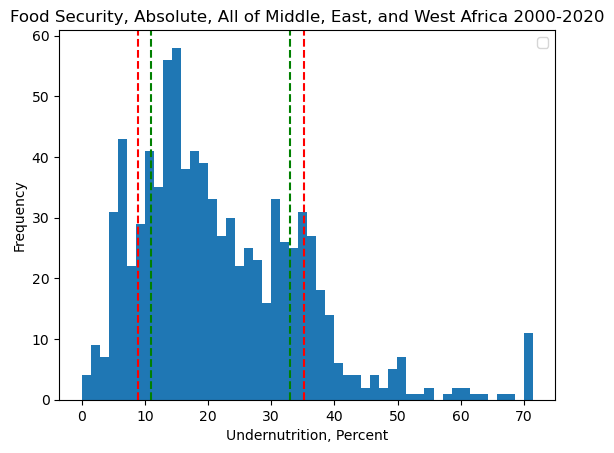

In [173]:
#
fs = undernourishment_timeseries[0,:,:].flatten()
fs_std_value = np.nanstd(fs)
fs_mean_value = np.nanmean(fs)
plt.hist(fs,bins=50)
plt.axvline(x=fs_mean_value+1*fs_std_value, color='red', linestyle='--')#, label=f'+1 Sigma')
plt.axvline(x=fs_mean_value-1*fs_std_value, color='red', linestyle='--')#, label=f'-1 Sigma')
plt.axvline(x=np.nanquantile(fs,.2), color='green', linestyle='--')#, label=f'+1 Sigma')
plt.axvline(x=np.nanquantile(fs,0.8), color='green', linestyle='--')#, label=f'-1 Sigma')

plt.title("Food Security, Absolute, All of Middle, East, and West Africa 2000-2020")
plt.xlabel("Undernutrition, Percent")
plt.ylabel("Frequency")
plt.legend()
plt.show()

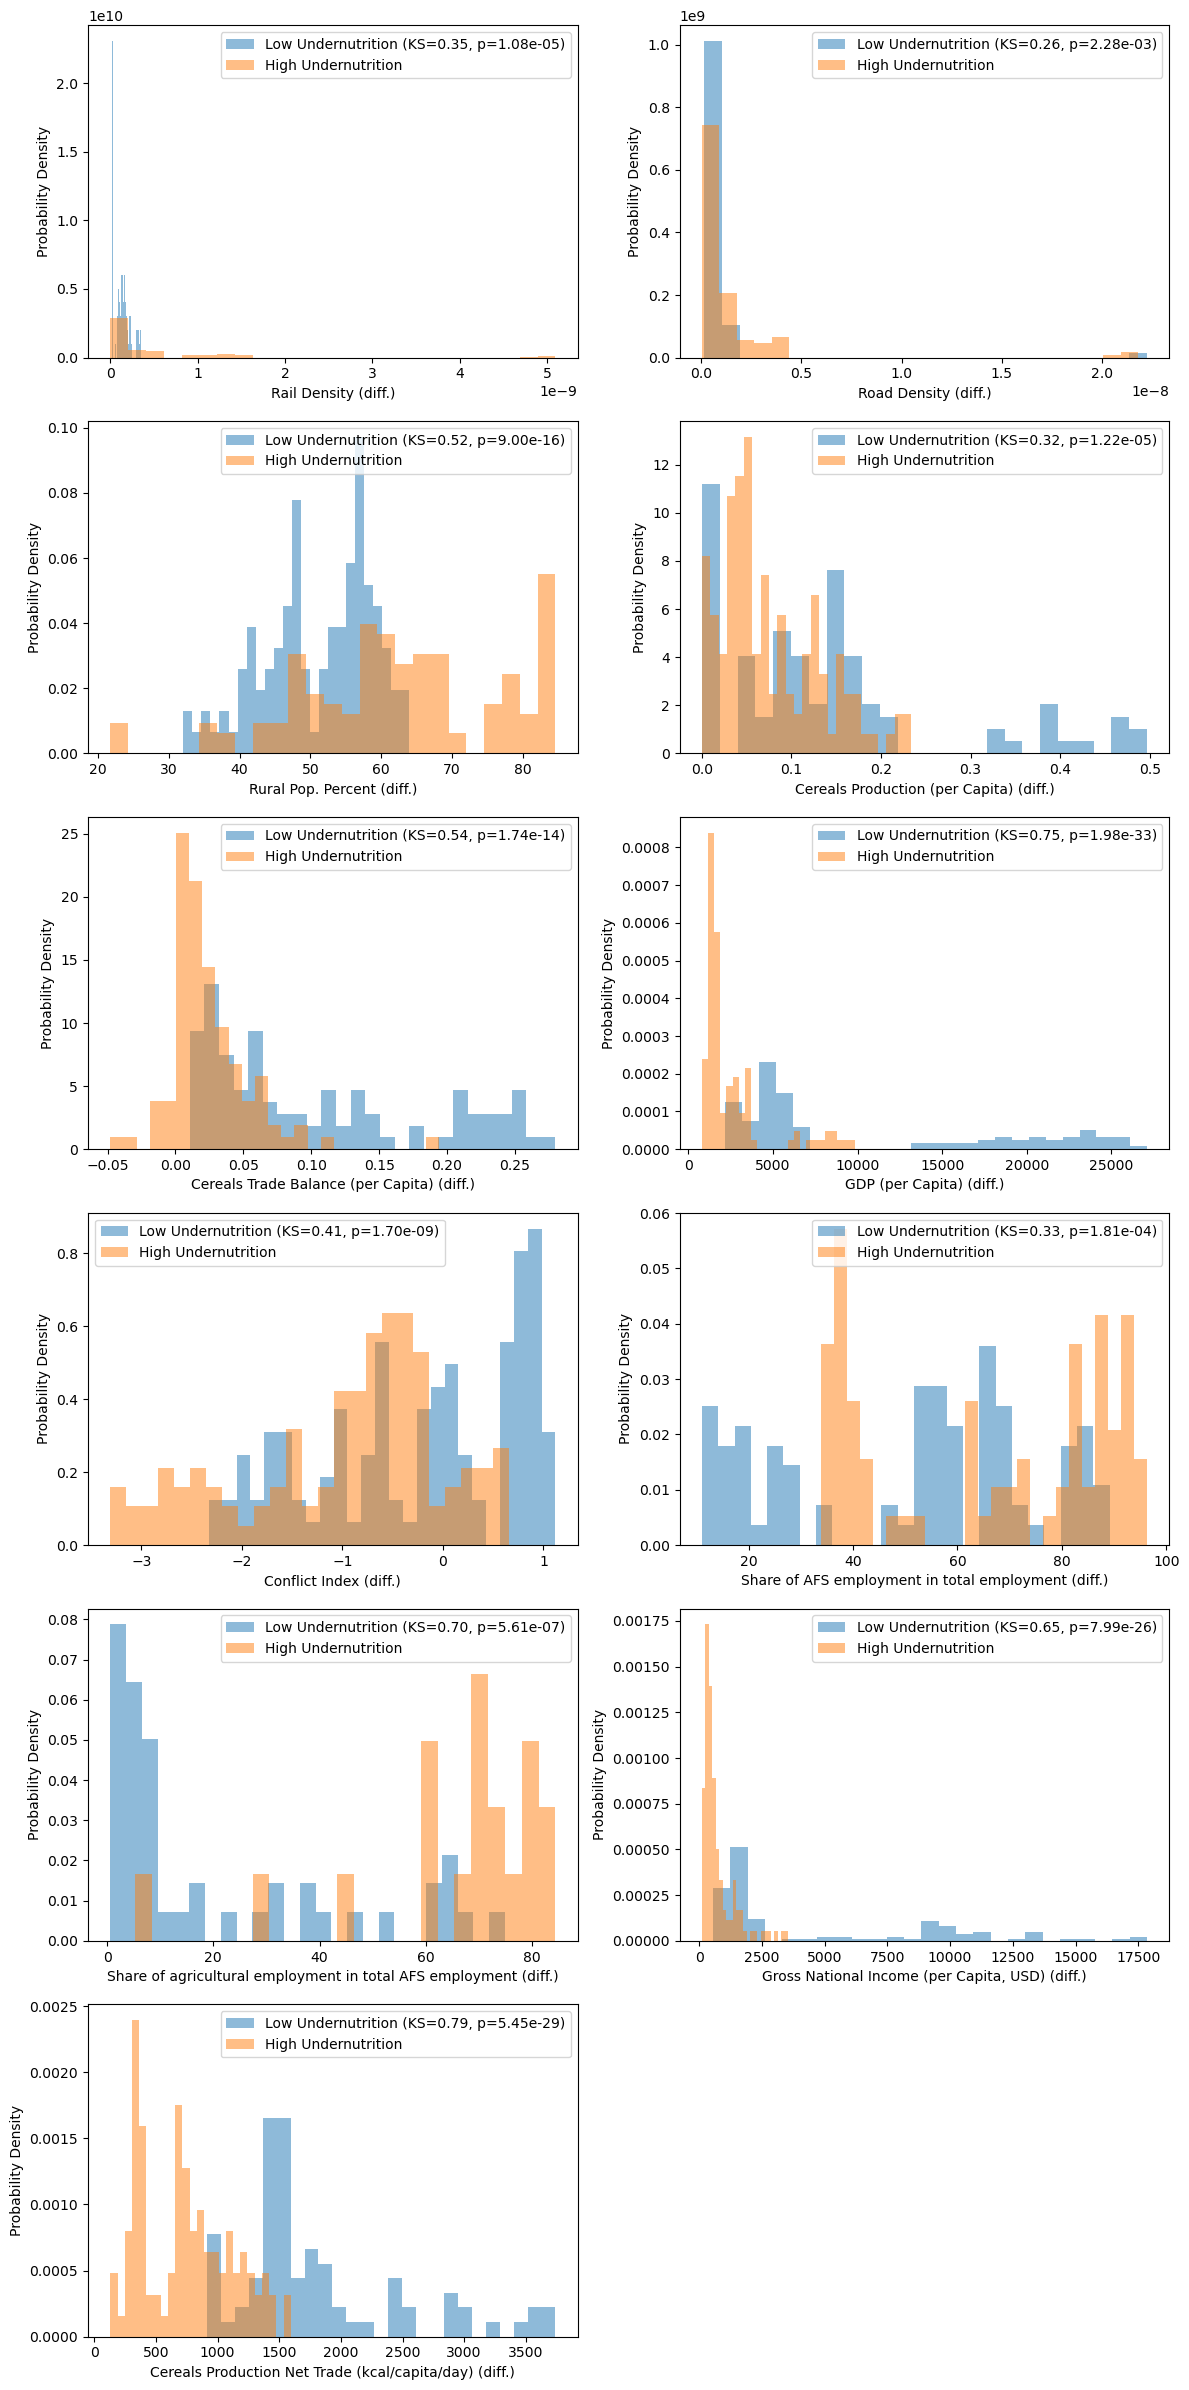

In [ ]:
from scipy.stats import ks_2samp

# Arrange the histograms for each variable in subplots.
num_vars = len(all_variables)
cols = 2
rows = (num_vars + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for idx, variable_name in enumerate(all_variables[0:]):
    ax = axes[idx]
    
    # Extract data for low and high undernutrition masks
    low_data = explanatory_variable[idx, :, :].flatten()[fs < fs_mean_value]# - fs_std_value]
    high_data = explanatory_variable[idx, :, :].flatten()[fs > fs_mean_value]# + fs_std_value]
    
    # Perform KS test
    ks_stat, ks_pvalue = ks_2samp(low_data[~np.isnan(low_data)], high_data[~np.isnan(high_data)])
    
    # Plot histogram for low undernutrition
    ax.hist(
        low_data,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(low_data), np.nanmax(low_data)),
        label=f"Low Undernutrition (KS={ks_stat:.2f}, p={ks_pvalue:.2e})"
    )
    
    # Plot histogram for high undernutrition
    ax.hist(
        high_data,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(high_data), np.nanmax(high_data)),
        label="High Undernutrition"
    )
    # Plot histogram for normal FS changes
    #normal_mask = (fs < fs_mean_value + fs_std_value) & (fs > fs_mean_value - fs_std_value)
    #x= explanatory_variable[idx, :, :].flatten()[normal_mask]
    #ax.hist(
    #    x,
    #    bins=25,
    #    density=True,
    #    alpha=0.5,
    #    range=(np.nanmin(x),np.nanmax(x)),
    #    label="Normal Undernutrition"
    #)
    
    ax.set_xlabel(variable_name + " (diff.)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Remove any unused axes (if the grid is larger than needed)
for ax in axes[num_vars:]:
    ax.remove()

plt.tight_layout()
plt.show()

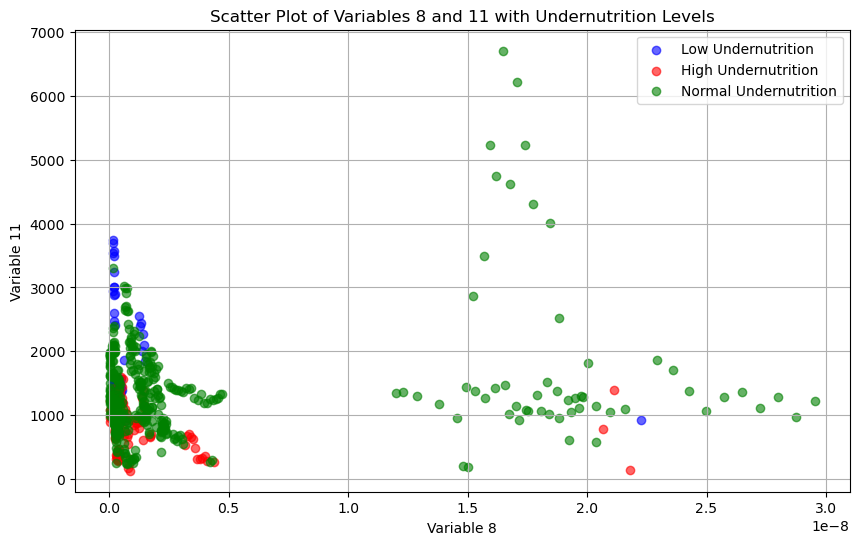

In [174]:
# Define thresholds for low, high, and normal undernutrition
low_threshold = fs_mean_value - fs_std_value
high_threshold = fs_mean_value + fs_std_value

# Extract variables 8 and 11
var8 = data_timeseries[1, :, :].flatten()
var11 = data_timeseries[10, :, :].flatten()

# Create a mask for each category
low_mask = fs < low_threshold
high_mask = fs > high_threshold
normal_mask = (fs >= low_threshold) & (fs <= high_threshold)

# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Plot low undernutrition
plt.scatter(var8[low_mask], var11[low_mask], color='blue', label='Low Undernutrition', alpha=0.6)

# Plot high undernutrition
plt.scatter(var8[high_mask], var11[high_mask], color='red', label='High Undernutrition', alpha=0.6)

# Plot normal undernutrition
plt.scatter(var8[normal_mask], var11[normal_mask], color='green', label='Normal Undernutrition', alpha=0.6)

# Add labels and legend
plt.xlabel('Variable 8')
plt.ylabel('Variable 11')
plt.title('Scatter Plot of Variables 8 and 11 with Undernutrition Levels')
plt.legend()
plt.grid(True)
plt.show()

In [180]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reshape as before
reshaped_data = data_timeseries.reshape(data_timeseries.shape[0], -1).T
flat_fs = fs.flatten()

# Label encoding: 0 = low, 1 = normal, 2 = high
labels = np.full(flat_fs.shape, 1)
labels[flat_fs < low_threshold] = 0
labels[flat_fs > high_threshold] = 2

# Impute & scale
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(reshaped_data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# PCA projection
pca = PCA(n_components=3)
proj = pca.fit_transform(data_scaled)


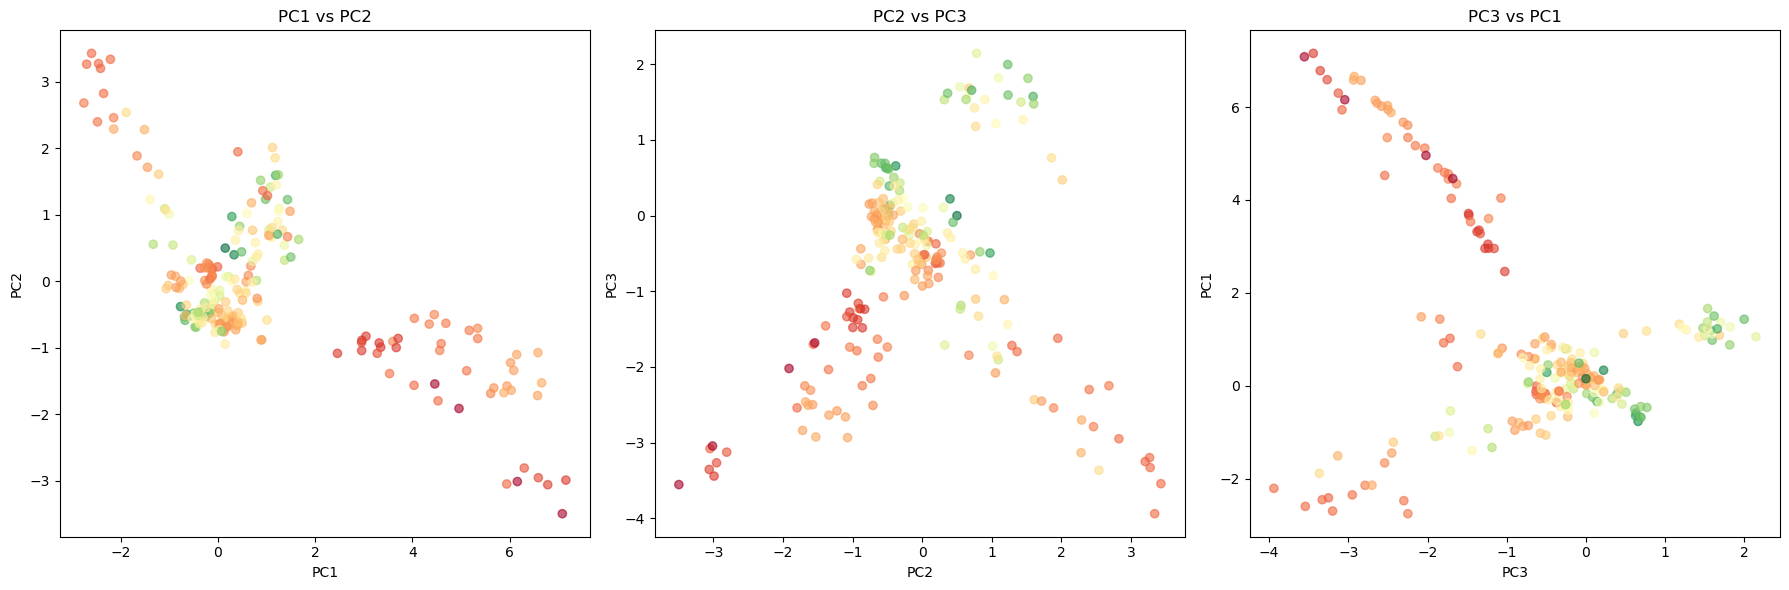

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fs_quantiled = fs.copy()
fs_quantiled[~np.hstack([(np.ones(undernourishment_timeseries.shape[2])*np.nansum((undernourishment_timeseries[0,i,:]<low_threshold))>0) & (np.ones(undernourishment_timeseries.shape[2])*np.nansum((undernourishment_timeseries[0,i,:]<low_threshold))<42) for i in range(undernourishment_timeseries.shape[1])])] = np.nan

# PC1 vs PC2
axes[0].scatter(proj[:, 0], proj[:, 1], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[0].set_title("PC1 vs PC2")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# PC2 vs PC3
axes[1].scatter(proj[:, 1], proj[:, 2], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[1].set_title("PC2 vs PC3")
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("PC3")

# PC3 vs PC1
axes[2].scatter(proj[:, 2], proj[:, 0], c=fs_quantiled, cmap='RdYlGn', alpha=0.6)
axes[2].set_title("PC3 vs PC1")
axes[2].set_xlabel("PC3")
axes[2].set_ylabel("PC1")

plt.tight_layout()
plt.show()

In [ ]:
# Define thresholds for low, normal, and high food insecurity
low_threshold = fs_mean_value - fs_std_value
high_threshold = fs_mean_value + fs_std_value

# Initialize a dictionary to store the results
country_ratios = {}

# Iterate over each country (axis 1 in fs)
for i, country in enumerate(areas):
    # Extract the food security data for the country
    country_fs = undernourishment_timeseries[0,i, :]

    # Count the number of years in each category
    total_years = np.sum(~np.isnan(country_fs))  # Exclude NaN values
    low_years = np.sum(country_fs < low_threshold)
    high_years = np.sum(country_fs > high_threshold)
    normal_years = total_years - low_years - high_years

    # Calculate the ratios
    low_ratio = low_years / total_years if total_years > 0 else 0
    normal_ratio = normal_years / total_years if total_years > 0 else 0
    high_ratio = high_years / total_years if total_years > 0 else 0
    
    # Store the results in the dictionary
    country_ratios[country] = {
        "Low Ratio": low_ratio,
        "Normal Ratio": normal_ratio,
        "High Ratio": high_ratio
    }

# Display the results
for country, ratios in country_ratios.items():
    print(f"{country}: {ratios}")

Angola: {'Low Ratio': 0.0, 'Normal Ratio': 0.6363636363636364, 'High Ratio': 0.36363636363636365}
Benin: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Burkina Faso: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Burundi: {'Low Ratio': 0, 'Normal Ratio': 0, 'High Ratio': 0}
Cabo Verde: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Cameroon: {'Low Ratio': 0.6363636363636364, 'Normal Ratio': 0.36363636363636365, 'High Ratio': 0.0}
Central African Republic: {'Low Ratio': 0.0, 'Normal Ratio': 0.7272727272727273, 'High Ratio': 0.2727272727272727}
Chad: {'Low Ratio': 0.0, 'Normal Ratio': 0.8181818181818182, 'High Ratio': 0.18181818181818182}
Comoros: {'Low Ratio': 0.0, 'Normal Ratio': 1.0, 'High Ratio': 0.0}
Congo: {'Low Ratio': 0.0, 'Normal Ratio': 0.7727272727272727, 'High Ratio': 0.22727272727272727}
Côte d'Ivoire: {'Low Ratio': 0.045454545454545456, 'Normal Ratio': 0.9545454545454546, 'High Ratio': 0.0}
Democratic Republic of the Congo: {'Low Ratio': 

In [169]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def symmetrical_colormap(cmap_settings, new_name = None ):
    ''' This function take a colormap and create a new one, as the concatenation of itself by a symmetrical fold.
    '''
    # get the colormap
    cmap = plt.cm.get_cmap(*cmap_settings)
    if not new_name:
        new_name = "sym_"+cmap_settings[0]  # ex: 'sym_Blues'
    
    # this defined the roughness of the colormap, 128 fine
    n= 128 
    
    # get the list of color from colormap
    colors_r = cmap(np.linspace(0, 1, n))    # take the standard colormap # 'right-part'
    colors_l = colors_r[::-1]                # take the first list of color and flip the order # "left-part"

    # combine them and build a new colormap
    colors = np.vstack((colors_l, colors_r))
    mymap = mcolors.LinearSegmentedColormap.from_list(new_name, colors)

    return mymap
# --- Quick test -------------------------
cmap_settings = ('Blues', None)  # provide int instead of None to "discretize/bin" the colormap
mymap = symmetrical_colormap(cmap_settings= cmap_settings, new_name =None )


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming `areas` is a list or array of unique area names
areas = np.unique(area_labels)  # Ensure unique areas
num_areas = len(areas)

# Create a colormap with as many colors as there are areas
cmap = plt.cm.get_cmap('tab20', num_areas)  # Use 'tab20' colormap for distinct colors

# Create a dictionary mapping each area to a color
area_colors = {area: cmap(i) for i, area in enumerate(areas)}


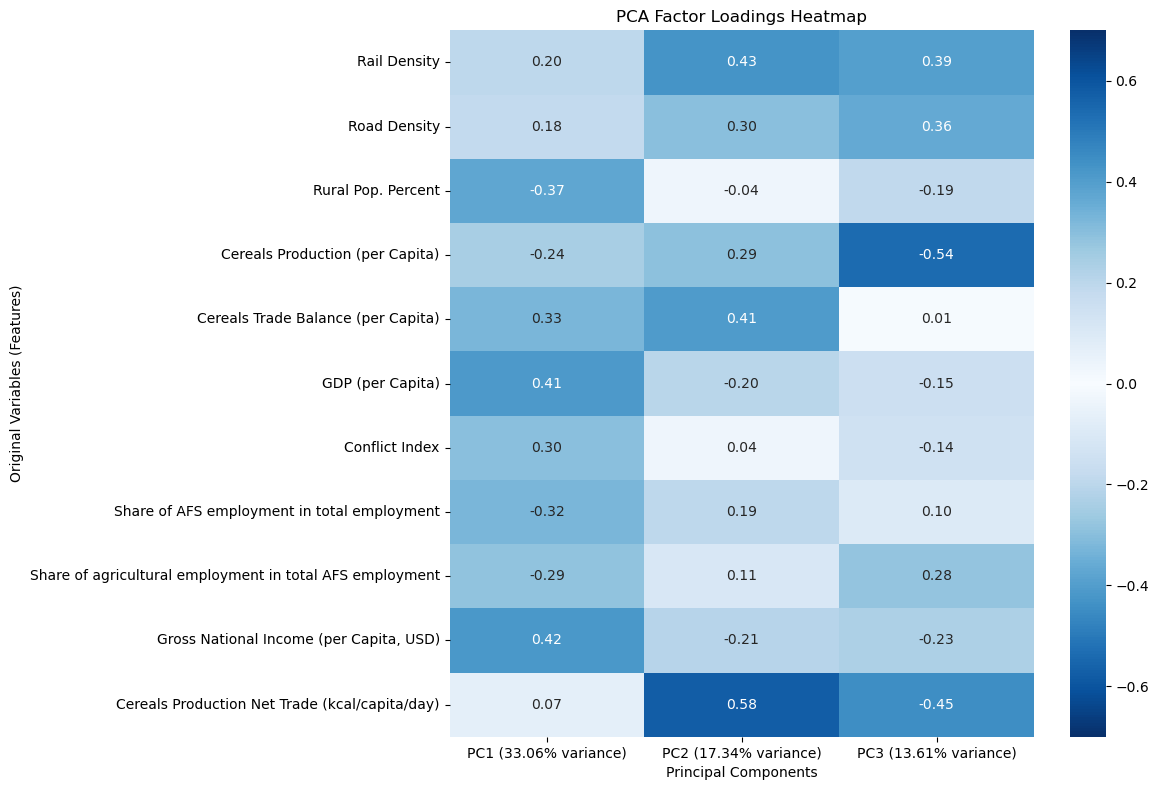

In [171]:
import seaborn as sns

# Calculate the percentage of variance explained by each PC
explained_variance = pca.explained_variance_ratio_ * 100

# Create a DataFrame for easy viewing
# Rows: Principal Components, Columns: Original Variables (Features)
# Transpose loadings so original features are rows and PCs are columns
loadings_df = pd.DataFrame(
    loadings.T, 
    columns=[f'PC{i+1} ({explained_variance[i]:.2f}% variance)' for i in range(len(explained_variance))], 
    index=feature_names
)

# Visualize the loadings with a heatmap

plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(loadings_df, cmap=mymap, vmin=-0.7, vmax=0.7, annot=True, fmt='.2f')
plt.title('PCA Factor Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Original Variables (Features)')
plt.tight_layout()  # Adjust layout
plt.show()

In [43]:
import umap.umap_ as umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
proj_umap = reducer.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
for i in range(3):
    mask = labels == i
    plt.scatter(proj_umap[mask, 0], proj_umap[mask, 1], alpha=0.6, color=colors[i], label=names[i])
plt.title("UMAP Projection of All Variables")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'umap.umap_'

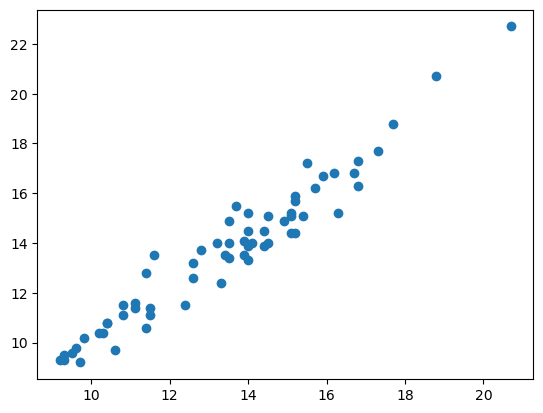

In [ ]:
plt.scatter(undernourishment_timeseries[0, 1:5, 1:],undernourishment_timeseries[0, 1:5, 0:-1])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import normalize
import numpy as np

# Assume:
#   data_timeseries: shape = (num_features, num_areas, num_years)
#   undernourishment_timeseries: shape = (1, num_areas, num_years)
num_features = data_timeseries.shape[0]
n_areas = data_timeseries.shape[1]
n_years = data_timeseries.shape[2]-1

# Reshape X to be (n_areas*n_years, num_features)
X = data_timeseries[1:3,:,1:].reshape(2,-1)
#X = np.vstack([data_timeseries[:,:,1:].transpose(1, 0, 2).reshape(-1, num_features).transpose(),undernourishment_timeseries[0, :, 0:-1].flatten()])
X = ((X.transpose() - np.nanmean(X,axis=1))/np.nanstd(X,axis=1)).transpose() #normalize features
#normalize features

# Flatten y from the FS timeseries; note we use the first channel
y = undernourishment_timeseries[0, :, 1:].reshape(1,-1)#np.diff(undernourishment_timeseries[0, :, :],axis=1).flatten()
y = ((y.transpose() - np.nanmean(y,axis=1))/np.nanstd(y,axis=1)).transpose() #normalize features

# Filter out rows with nan values
mask = (~np.isnan(y) & ~np.isnan(X).any(axis=0))[0,:]
X_clean = X.transpose()[mask]#.reshape(-1,1)
y_clean = y.transpose()[mask]

# Initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lr = LinearRegression()
# 5-fold cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(lr, X_clean, y_clean, cv=tscv, scoring='r2')

print("Cross-validated R^2 scores:", scores)
print("Mean R^2 score:", np.mean(scores))

ValueError: Input contains NaN.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import normalize
import numpy as np

# Assume:
#   data_timeseries: shape = (num_features, num_areas, num_years)
#   undernourishment_timeseries: shape = (1, num_areas, num_years)
num_features = data_timeseries.shape[0]
n_areas = data_timeseries.shape[1]
n_years = data_timeseries.shape[2]-1

# Reshape X to be (n_areas*n_years, num_features)
X = undernourishment_timeseries[0, :, 0:-1].flatten() 
X = ((X.transpose() - np.nanmean(X))/np.nanstd(X))
#normalize features

# Flatten y from the FS timeseries; note we use the first channel
y = undernourishment_timeseries[0, :, 1:].flatten()#np.diff(undernourishment_timeseries[0, :, :],axis=1).flatten()

# Filter out rows with nan values
mask = ~np.isnan(y) & ~np.isnan(X)#.any(axis=0)
X_clean = X.transpose()[mask].reshape(-1,1)
y_clean = y.transpose()[mask]

# Initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lr = LinearRegression()
# 5-fold cross validation

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(lr , X_clean, y_clean, cv=tscv, scoring='r2')

print("Cross-validated R^2 scores:", scores)
print("Mean R^2 score:", np.mean(scores))

Cross-validated R^2 scores: [0.96383559 0.96860403 0.98037761 0.98957444 0.99073804]
Mean R^2 score: 0.9786259430338873


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=2,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_clean, y_clean)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (neg RMSE):", grid_search.best_score_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
Best Parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score (neg RMSE): -1.6111787341800778


### 2. Changes

In [61]:
undernourishment_timeseries.shape 

(1, 43, 23)

In [65]:
norm_fs= ((undernourishment_timeseries[0,:,:]-np.nanmean(undernourishment_timeseries[0,:,:],axis=0))/np.nanstd(undernourishment_timeseries[0,:,:],axis=0))

Text(0, 0.5, 'Frequency')

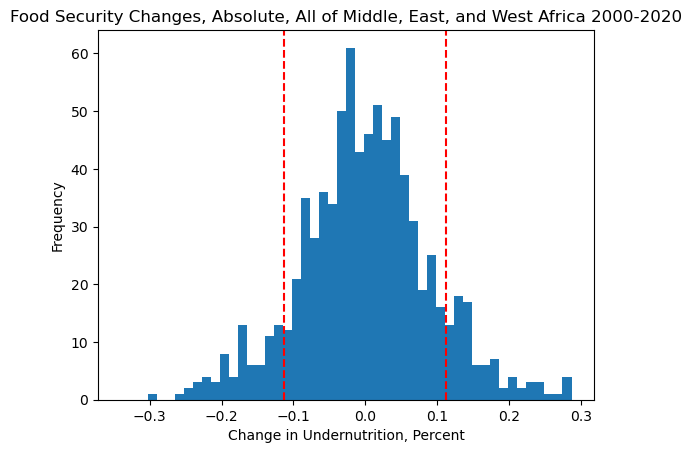

In [66]:
#find histogram of percent differences
fs_changes = np.diff(norm_fs,axis=1).flatten() #food security change data,flatttened
plt.hist(fs_changes,bins=50,range=(np.nanquantile(fs_changes,.01),np.nanquantile(fs_changes,.99)))
fs_changes_std_value = np.nanstd(fs_changes)
fs_changes_mean_value = np.nanmean(fs_changes)
plt.axvline(x=fs_changes_mean_value+1*fs_changes_std_value, color='red', linestyle='--', label=f'Std: {fs_changes_std_value:.2f}')
plt.axvline(x=fs_changes_mean_value-1*fs_changes_std_value, color='red', linestyle='--', label=f'Std: {fs_changes_std_value:.2f}')
plt.title("Food Security Changes, Absolute, All of Middle, East, and West Africa 2000-2020")
plt.xlabel("Change in Undernutrition, Percent")
plt.ylabel("Frequency")

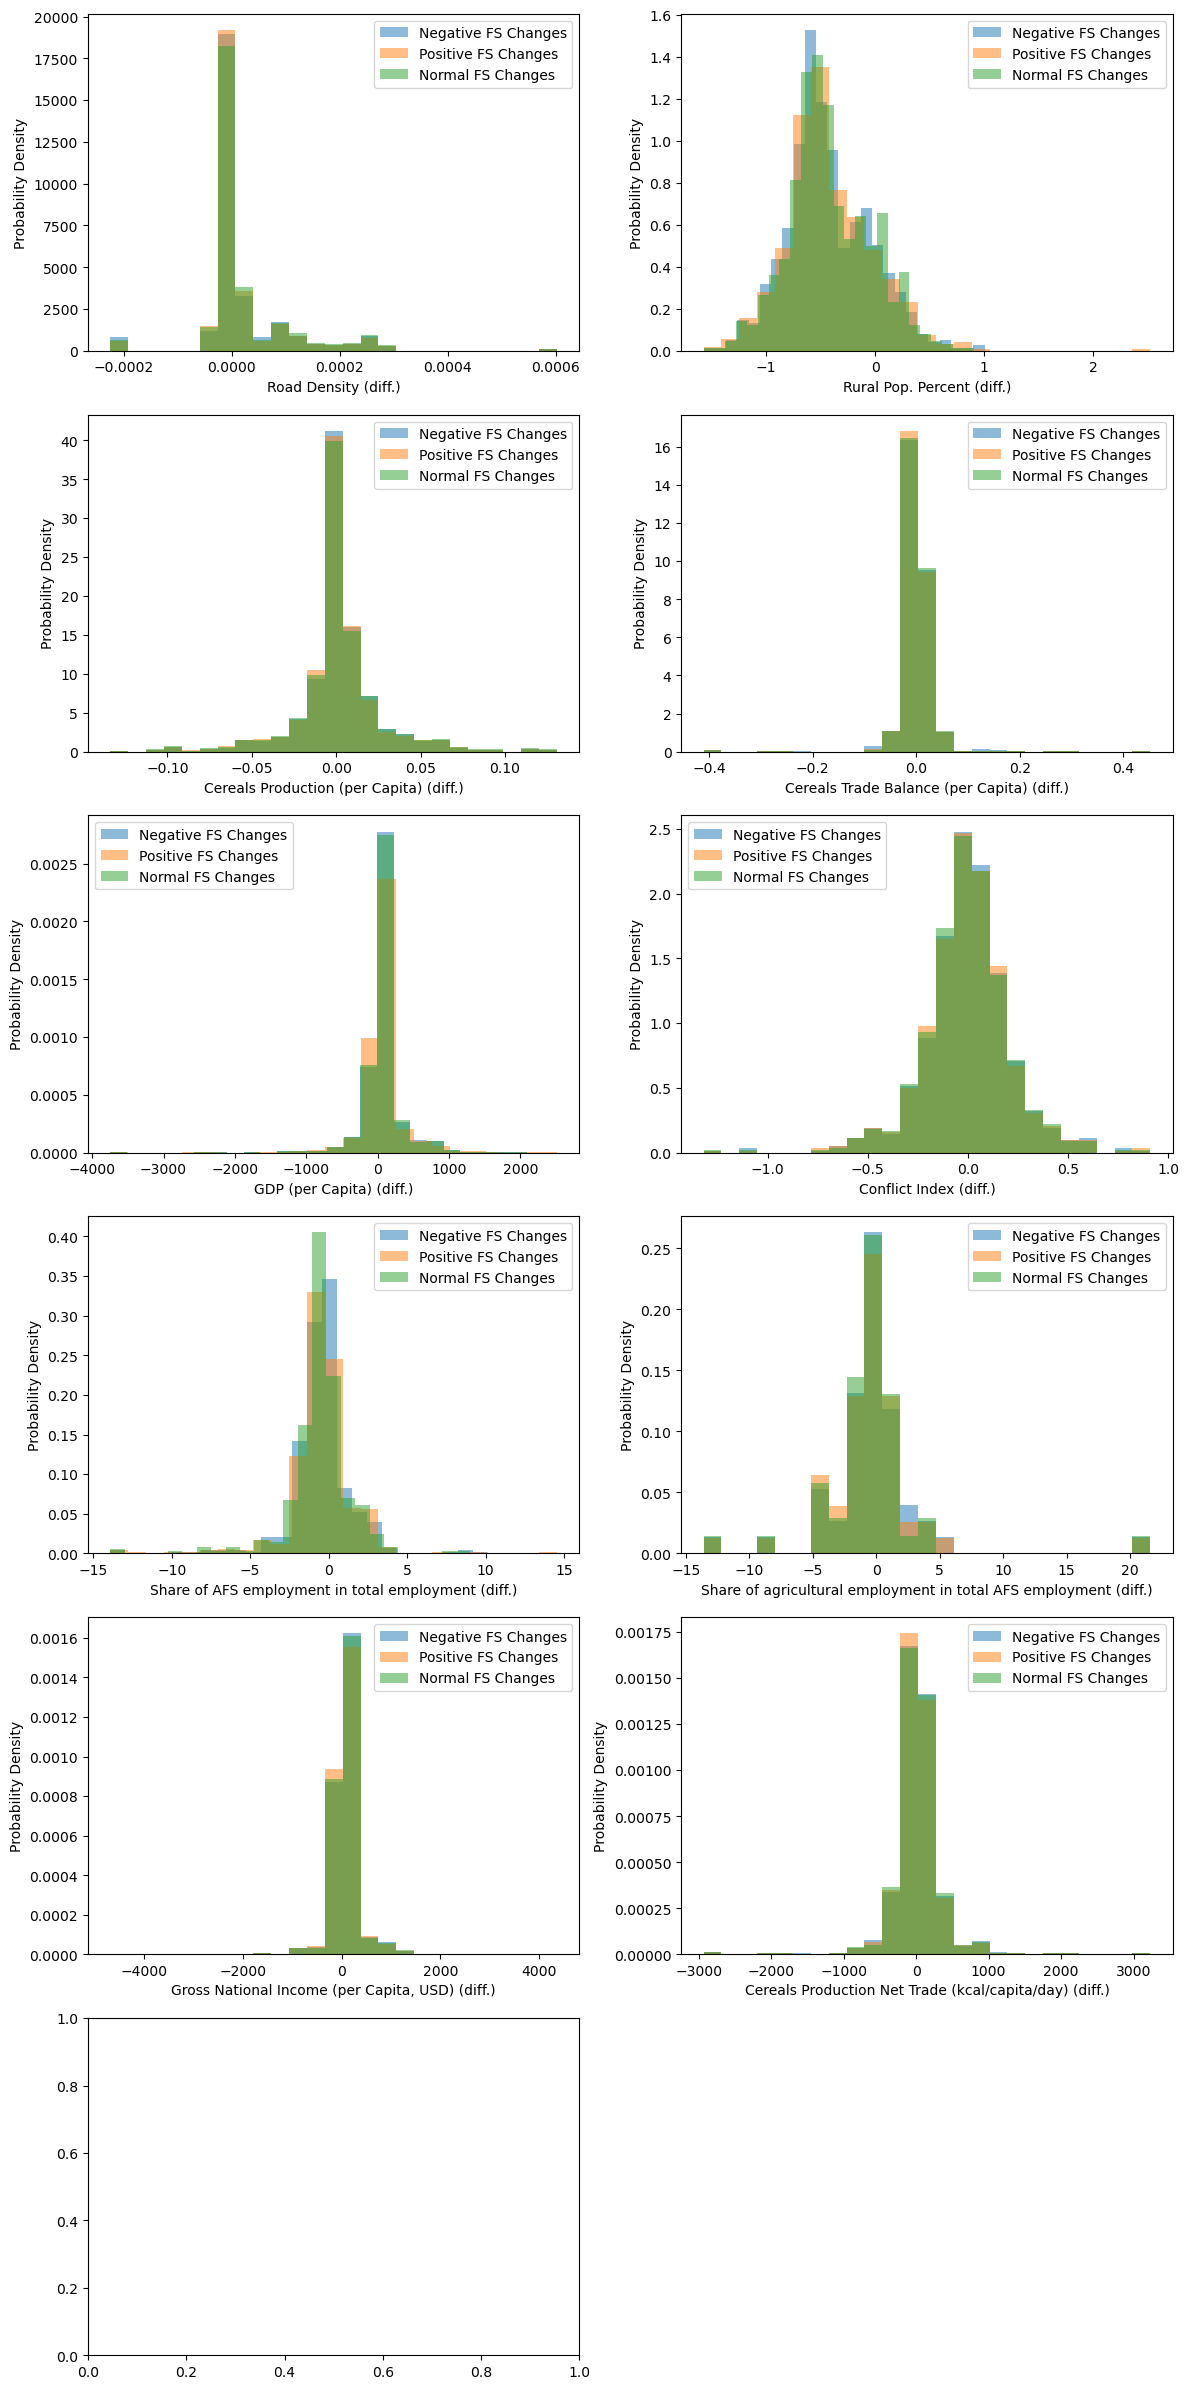

In [67]:
explanatory_variable = np.diff(data_timeseries[:,:,:],axis=2)#/data_timeseries[1, :, :-1] * 100 #food security change data,flatttened

# Arrange the histograms for each variable in subplots.
num_vars = len(all_variables)
cols = 2
rows = (num_vars + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()


for idx, variable_name in enumerate(all_variables[1:]):
    ax = axes[idx]
    idx=idx+1
    # Plot histogram for negative FS changes
    x=explanatory_variable[idx, :, :].flatten()[fs_changes < fs_changes_mean_value + fs_changes_std_value]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Negative FS Changes"
    )
    
    # Plot histogram for positive FS changes
    x=explanatory_variable[idx, :, :].flatten()[fs_changes > fs_changes_mean_value - fs_changes_std_value]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Positive FS Changes"
    )
    
    # Plot histogram for normal FS changes
    normal_mask = (fs_changes < fs_changes_mean_value + fs_changes_std_value) & (fs_changes > fs_changes_mean_value - fs_changes_std_value)
    x= explanatory_variable[idx, :, :].flatten()[normal_mask]
    ax.hist(
        x,
        bins=25,
        density=True,
        alpha=0.5,
        range=(np.nanmin(x),np.nanmax(x)),
        label="Normal FS Changes"
    )
    
    ax.set_xlabel(variable_name + " (diff.)")
    ax.set_ylabel("Probability Density")
    ax.legend()

# Remove any unused axes (if the grid is larger than needed)
for ax in axes[num_vars:]:
    ax.remove()
plt.title("")
plt.tight_layout()
plt.show()


# Adding Seasonality to the Food Balance Sheet

#### 1. Beginning by the classic counterfactual -- one where stocks seems to be growing, one where domestic supply is still extremely low. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load the two CSV files
df_old = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_1961-2013.csv')
df_new = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_2010-2022.csv')

# Ensure 'Year' column is numeric
df_old['Year'] = pd.to_numeric(df_old['Year'], errors='coerce')
df_new['Year'] = pd.to_numeric(df_new['Year'], errors='coerce')

# Filter the old dataframe to include only years up to 2009
df_old_filtered = df_old[df_old['Year'] <= 2009]

# Combine the filtered old dataframe with the new dataframe
FBS_Cereals_Complete_National = pd.concat([df_old_filtered, df_new], ignore_index=True)

# Optional: sort by year and reset index
FBS_Cereals_Complete_National = FBS_Cereals_Complete_National.sort_values(by='Year').reset_index(drop=True)
FBS_Cereals_Complete_National['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
National_Populations=pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv")

<AxesSubplot: title={'center': 'Senegal Food Supply (kcal/capita/day)'}, xlabel='Year', ylabel='Food Supply (kcal/capita/day)'>

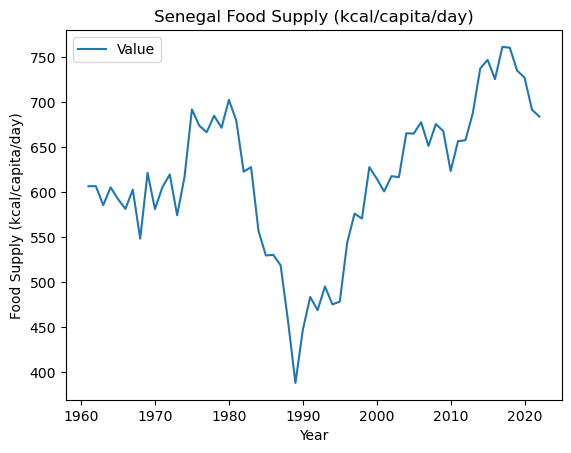

In [9]:
FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Element =='Food supply (kcal/capita/day)') & (FBS_Cereals_Complete_National.Area == 'Angola')].groupby('Year').sum().reset_index().plot(x='Year',y='Value',title="Senegal Food Supply (kcal/capita/day)",ylabel="Food Supply (kcal/capita/day)",xlabel="Year")

Text(0, 0.5, 'alpha')

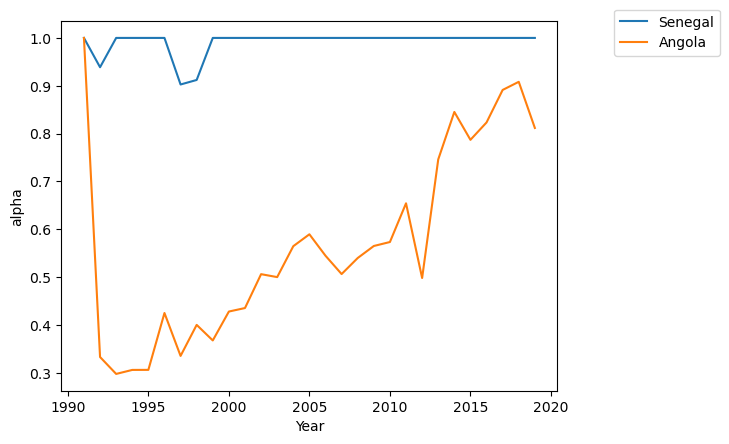

In [10]:
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365 # 1200 kcal/year

national_years = FBS_Cereals_Complete_National.Year.unique()
national_years = national_years[30:-3]
target_nations =  ['Senegal','Angola']
national_stocks = np.zeros((len(target_nations),len(national_years)))+0.01
national_percapita_stocks = np.zeros((len(target_nations),len(national_years)))+0.01


national_alpha = np.ones((len(target_nations),len(national_years)))
for r,region in enumerate(target_nations):
    #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
    seed = 0.03
    loss = 0.04
    cereal_caloric_density = 2609*1000 # kcal/ton 
    caloric_requirment = 1240*365 # 1200 kcal/year
    #stocks[r,0] = regional_cereals_stocks_obs[region][30]*1000
    for i in np.arange(1,len(national_years)):
        processing = 0# regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Processing
        economic_use = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Other + regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Feed
        Pop = 1000*National_Populations[(National_Populations.Year == national_years[i]) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0] #[people]
        residuals = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Residuals
        Y = 1000*FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value
        try:
            trade_balance = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value - FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value
            trade_balance = trade_balance*1000 # tons
        except:
            trade_balance =0 
            print(region)
        food = Pop*caloric_requirment/cereal_caloric_density # in tons
        total_supply = Y+trade_balance
        if national_stocks[r,i-1] + trade_balance + (Y*(1-seed-loss) - national_alpha[r,i]*food*(1+processing) - total_supply*economic_use) > 0:
            national_alpha[r,i] = 1
        else:
            national_alpha[r,i] = (national_stocks[r,i-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
            national_alpha[r,i] = national_alpha[r,i].clip(0,1)
        dstock = trade_balance + Y*(1-seed-loss) - national_alpha[r,i]*food - total_supply*(economic_use+processing+residuals)
        national_stocks[r,i] = national_stocks[r,i-1] + dstock #- stocks[r,i-1]*0.33 #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
        #national_percapita_stocks[r,i] = national_stocks[r,i]/Pop



colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)

for r,region in enumerate(target_nations):
    if national_alpha[r,:].mean()<1.1: #(region == "Western Africa"):
        plt.plot(national_years,national_alpha[r,:],label=region)#color=colors[r])
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('alpha')


#### 2. Add monthly resolution

In [11]:
national_crop_calendar = pd.read_csv(r"..\Data/1DSUM-National/crop_calendar_gaul0.csv",delimiter=';')

In [12]:

# 1. Calculate months from dekads
def dekad_to_month(dekad):
    # Each month has 3 dekads, so we divide by 3 and round up
    return min(12, max(1, (dekad - 1) // 3 + 1))

# Add harvest_start_month and harvest_end_month columns
national_crop_calendar['harvest_start_month'] = national_crop_calendar['eos_s'].apply(dekad_to_month)
national_crop_calendar['harvest_end_month'] = national_crop_calendar['eos_e'].apply(dekad_to_month)

# 2. Create monthly harvest proportions
def create_harvest_array(start_month, end_month):
    # Create an array of zeros
    arr = np.zeros(12)
    
    # Handle wrap-around case (e.g., if harvest starts in November and ends in February)
    if start_month <= end_month:
        # Set to 1 for each month in the harvest period (inclusive of end_month)
        for month in range(start_month, end_month + 1):
            arr[month - 1] = 1
    else:
        # Set to 1 for months from start_month to December
        for month in range(start_month, 13):
            arr[month - 1] = 1
        # Set to 1 for months from January to end_month
        for month in range(1, end_month + 1):
            arr[month - 1] = 1
    
    # 3. Normalize the array
    if arr.sum() > 0:  # Avoid division by zero
        arr = arr / arr.sum()
    
    return arr

# Apply the function to each row
national_crop_calendar['monthly_harvest_proportions'] = national_crop_calendar.apply(
    lambda row: create_harvest_array(row['harvest_start_month'], row['harvest_end_month']), 
    axis=1
)

In [23]:
FBS_Cereals_Complete_National.Item.unique()

array(['Wheat and products', 'Oats', 'Maize and products',
       'Rice (Milled Equivalent)', 'Cereals, Other',
       'Barley and products', 'Rye and products', 'Sorghum and products',
       'Millet and products', 'Cereals, other', 'Rice and products'],
      dtype=object)

In [25]:
cereal_caloric_density = 2609*1000 # kcal/ton 
caloric_requirment = 1240*365/12 # 1200 kcal/month

national_years = FBS_Cereals_Complete_National.Year.unique()
national_years = national_years[30:-3]
target_nations =  ['Senegal','Angola']
national_stocks = np.zeros((len(target_nations),len(national_years)*12))+0.01
national_percapita_stocks = np.zeros((len(target_nations),len(national_years)*12))+0.01

national_alpha = np.ones((len(target_nations),len(national_years)*12))
for r,region in enumerate(target_nations):
    #stocks[r,0] = regional_stocks_df[(regional_stocks_df.region == region) & (regional_stocks_df.Year == years[0])].stock.values*1000 # tons
    seed = 0.03
    loss = 0.04
    cereal_caloric_density = 2609*1000 # kcal/ton 
    caloric_requirment = 1240*365/12 # 1200 kcal/month
    for i in np.arange(0,len(national_years)):
        print(i)
        for month in np.arange(12):
            processing = 0# regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Processing
            economic_use = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Other + regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Feed
            Pop = 1000*(National_Populations[(National_Populations.Year == national_years[i]) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]   +   (month/12)*(National_Populations[(National_Populations.Year == national_years[i]+1) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]   -   National_Populations[(National_Populations.Year == national_years[i]) & (National_Populations.Area == region ) & (National_Populations.Element == 'Total Population - Both sexes')].Value.values[0]))
            residuals = 0#regional_time_series[region].iloc[np.where(regional_time_series[region].Year == years[i])[0][0]].Residuals
            Y = 0 
            for cereal_item in FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)].Item.unique():
                crop_short = cereal_item.split(' ')[0]
                try:
                    harvest_percentage = national_crop_calendar[(national_crop_calendar.name0_shr == region)&(national_crop_calendar.crop_name == crop_short)].monthly_harvest_proportions.iloc[0][month]
                except:
                    harvest_percentage = 1/12
                Y +=  1000*harvest_percentage*FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Production') & (FBS_Cereals_Complete_National.Area == region)& (FBS_Cereals_Complete_National.Item == cereal_item)].iloc[0].Value
            
            try:
                trade_balance = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value - FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == national_years[i])&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == region)].groupby('Year').sum().reset_index().iloc[0].Value
                trade_balance = trade_balance*1000/12 # tons
            except:
                trade_balance =0 
                print(region)
            food = Pop*caloric_requirment/cereal_caloric_density # in tons
            total_supply = Y+trade_balance
            if national_stocks[r,12*i+month-1] + trade_balance + (Y*(1-seed-loss) - national_alpha[r,12*i+month]*food*(1+processing) - total_supply*economic_use) > 0:
                national_alpha[r,12*i+month] = 1
            else:
                national_alpha[r,12*i+month] = (national_stocks[r,12*i+month-1] + trade_balance + Y*(1-seed-loss) - total_supply*economic_use)/(food*(1+processing))
                national_alpha[r,12*i+month] = national_alpha[r,12*i+month].clip(0,1)
            dstock = trade_balance + Y*(1-seed-loss) - national_alpha[r,12*i+month]*food - total_supply*(economic_use+processing+residuals)
            national_stocks[r,12*i+month] = national_stocks[r,12*i+month-1] + dstock #- stocks[r,i-1]*0.33 #*stock_use_ratio #- 0.1*stocks[r,i-1] # 10% of the stocks are lost each year
            #national_percapita_stocks[r,i] = national_stocks[r,i]/Pop




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


Text(0, 0.5, 'alpha')

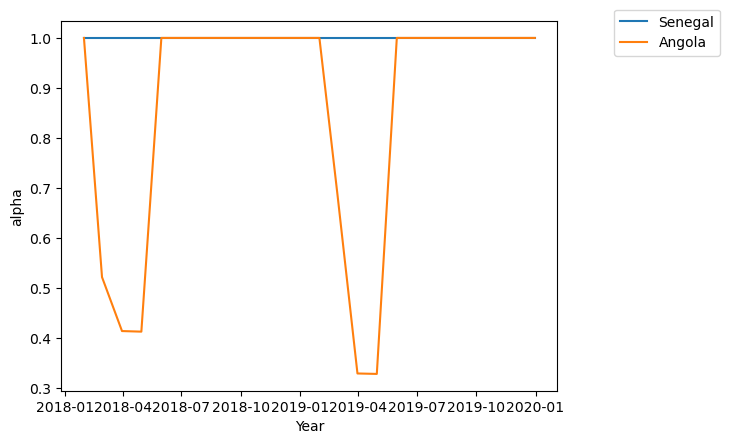

In [47]:
colors = plt.cm.tab20c.colors  # 20 colors, plus an additional one from the "tab20c" colormap
# Make sure that there are 21 colors by repeating the last one if needed
colors = list(colors) + [colors[-1]]
fig = plt.figure()
ax = plt.subplot(111)

monthly_time =  pd.date_range(start=str(national_years[0]), end=str(national_years[-1]+1),freq="M")
for r,region in enumerate(target_nations):
    if national_alpha[r,:].mean()<1.1: #(region == "Western Africa"):
        plt.plot(monthly_time[-24:],national_alpha[r,:][-24:],label=region)#color=colors[r])
        ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel('Year')
ax.set_ylabel('alpha')

DatetimeIndex(['1991-01-31', '1991-02-28', '1991-03-31', '1991-04-30',
               '1991-05-31', '1991-06-30', '1991-07-31', '1991-08-31',
               '1991-09-30', '1991-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', length=348, freq='M')